In [113]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import datetime

# Using Twitter to Predict Presidential Polling Outcomes

I chose to examine the four candidates with the highest amount of funding as of September 2019 AND September 2015 and make a prediction for the Democratic nominee for the 2020 Presidential election cycle. Past data from 2015 was also used to train the model. The data was obtained through the process of running the command 'GetOldTweets3' and 'Twint' through the command line for specific parameters for each candidate.

I pulled all tweets with the strings **'warren'**, **'sanders'**, **'biden'**, and **'buttigieg'** (along with variations 'butigieg' and 'buttigeig') for the first week (days 1 - 7) of May, June, July, August, and September of 2019. I again did this for **'clinton**, **'sanders'**, **'trump'**, and **'cruz'** for the first week (days 1 - 7) of May, June, July, August, and September of 2015. The tweets for each year were then merged at the command line into two large CSVs resulting in a total of over **_3 million_** tweets. 

Other data was taken from national polling data [for 2019](https://projects.fivethirtyeight.com/polls/president-primary-d/) and [2015](https://en.wikipedia.org/wiki/Nationwide_opinion_polling_for_the_2016_United_States_presidential_election). Donation and financial data was taken for both years from the offical [FEC database](https://www.fec.gov/data/candidates/president/?election_year=2020&cycle=2020&election_full=true).

All tweets were analyzed using the NLK toolkit for Python called [TextBlob](https://textblob.readthedocs.io/en/dev/advanced_usage.html#sentiment-analyzers) which returns sentiment values for words and phrases. The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range \[-1.0, 1.0]. The subjectivity is a float within the range \[0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [2]:
tweets = pd.read_csv('merged_tweets.csv', parse_dates=['date'])

In [3]:
tweets.dtypes

date         datetime64[ns]
username             object
to                   object
replies               int64
retweets              int64
favorites             int64
text                 object
geo                 float64
mentions             object
hashtags             object
id                    int64
permalink            object
dtype: object

In [4]:
tweets.head()
len(tweets.index)

1721388

In [5]:
# Dropping tweets that came up for more than one candidate name
tweets = tweets.drop_duplicates()

In [6]:
len(tweets.index)

1526979

In [7]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1526979 entries, 0 to 1721387
Data columns (total 12 columns):
date         1526979 non-null datetime64[ns]
username     1526979 non-null object
to           1119538 non-null object
replies      1526979 non-null int64
retweets     1526979 non-null int64
favorites    1526979 non-null int64
text         1521033 non-null object
geo          0 non-null float64
mentions     272520 non-null object
hashtags     181746 non-null object
id           1526979 non-null int64
permalink    1526979 non-null object
dtypes: datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 151.4+ MB


In [8]:
len(tweets['username'].unique())

506306

In [75]:
counts = tweets['username'].value_counts()

res = tweets[~tweets['username'].isin(counts[counts < 300].index)]
res['username'].value_counts()

BernieOrVest       811
thehill            803
WeWantPete         697
RedditForPete      600
RyonRobynson       550
Foxmental_X        487
Birdonalift        486
TomthunkitsMind    485
succestattoo       482
stephlynn1982      477
ToastPete          477
raybae689          466
PelosiSquadFive    456
WhyKelly2          450
AIIAmericanGirI    428
wbellauthor        391
PatrickAKarlson    390
cookmichaelv13     388
im2b               387
VABVOX             386
Invisible_Ride     382
muhitreza          381
FriendsofJimmys    373
paula4buttigieg    361
reesetheone1       349
cahulaan           334
JoinPatriotify     332
JoeFreedomLove     330
proviewsusa        325
JayJay5077         324
evilberniefan      323
Helpers4Pete       322
deenie7940         313
GallivanScott      309
SoundsKugle        305
Mel_Ankoly         303
TheOnlyKAVIN       302
PoliticalAnt       301
CriticalRiposte    300
scaryfoxx          300
Name: username, dtype: int64

In [10]:
tweets.mentions = tweets['mentions'].str.lower()
tweets.mentions.value_counts()

@joebiden                                                                                                                                                                                                                                                                                     20389
@berniesanders                                                                                                                                                                                                                                                                                19416
@petebuttigieg                                                                                                                                                                                                                                                                                18737
@senwarren                                                                                                                  

In [11]:
from textblob import TextBlob 
def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

tweets['sentiment'] = tweets['text'].apply(sentiment_calc)

In [12]:
def subjectivity_calc(text):
    try:
        return TextBlob(text).sentiment.subjectivity
    except:
        return None

tweets['subjectivity'] = tweets['text'].apply(subjectivity_calc)

In [13]:
def polarity_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

tweets['polarity'] = tweets['text'].apply(polarity_calc)

In [14]:
#tweets.to_csv(r'tweets_with_polarity.csv')

In [3]:
tweets = pd.read_csv('tweets_with_polarity.csv', encoding='ISO-8859-1')

In [63]:
tweets.dtypes

Unnamed: 0        int64
date             object
username         object
to               object
replies           int64
retweets          int64
favorites         int64
text             object
geo             float64
mentions         object
hashtags         object
id                int64
permalink        object
sentiment        object
subjectivity    float64
polarity        float64
dtype: object

In [4]:
biden_mask = ((tweets['text'].str.contains('biden', case=False)) | 
                  (tweets['mentions'].str.contains('biden', case=False)) | 
                  (tweets['to'].str.contains('biden', case=False)))

tweets['biden'] = 0
tweets.biden[biden_mask] = 1


warren_mask = ((tweets['text'].str.contains('warren', case=False)) | 
                  (tweets['mentions'].str.contains('warren', case=False)) | 
                  (tweets['to'].str.contains('warren', case=False)))

tweets['warren'] = 0
tweets.warren[warren_mask] = 1

sanders_mask = ((tweets['text'].str.contains('sanders', case=False)) | 
                  (tweets['mentions'].str.contains('sanders', case=False)) | 
                  (tweets['to'].str.contains('sanders', case=False)))

tweets['sanders'] = 0
tweets.sanders[sanders_mask] = 1

buttigieg_mask = ((tweets['text'].str.contains('buttigieg', case=False)) | 
                  (tweets['mentions'].str.contains('buttigieg', case=False)) | 
                  (tweets['to'].str.contains('buttigieg', case=False)) |
                  (tweets['text'].str.contains('buttigig', case=False)) |
                  (tweets['mentions'].str.contains('buttigig', case=False)) | 
                  (tweets['to'].str.contains('buttigig', case=False)) |
                  (tweets['text'].str.contains('buttigeig', case=False)) |
                  (tweets['mentions'].str.contains('buttigeig', case=False)) | 
                  (tweets['to'].str.contains('buttigeig', case=False)))

tweets['buttigieg'] = 0
tweets.buttigieg[buttigieg_mask] = 1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Vers

In [33]:
pd.set_option('display.max_columns', 50)
tweets.head(20)

,Unnamed: 0,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink,sentiment,subjectivity,polarity,biden,warren,sanders,buttigieg,reactions,weighted_polarity,month,biden_only,warren_only,sanders_only,buttigieg_only
0,0,2019-08-06 23:59:54,TexasBluein20,NaN,1,4,10,Biden leads Democrats as minorities favor most...,NaN,NaN,NaN,1158890472179478529,https://twitter.com/TexasBluein20/status/11588...,"Sentiment(polarity=0.5, subjectivity=0.5)",0.500000,0.500000,1,0,0,0,15,0.750000,2019-08,1,0,0,0
1,1,2019-08-06 23:59:53,AverageJoe3210,JoeBiden,0,0,1,No they are not. Legally registered voters can...,NaN,NaN,#PartisanHack,1158890468748472325,https://twitter.com/AverageJoe3210/status/1158...,"Sentiment(polarity=-0.1, subjectivity=0.2)",0.200000,-0.100000,1,0,0,0,1,-0.103333,2019-08,1,0,0,0
2,2,2019-08-06 23:59:48,janiceduke54,NaN,0,0,0,@JoeBiden Chris Matthews just stated on his sh...,NaN,@joebiden,NaN,1158890449328676865,https://twitter.com/janiceduke54/status/115889...,"Sentiment(polarity=-0.008810763888888906, subj...",0.638542,-0.008811,1,0,0,0,0,-0.008811,2019-08,1,0,0,0
3,3,2019-08-06 23:59:48,RhetoricButler,ScreamngEagle,0,0,0,@CoryBooker @morningmika @JoeNBC @JoeBiden @Re...,NaN,@corybooker @morningmika @joenbc @joebiden @re...,#denyit #TellTheTruthhttps,1158890448355651584,https://twitter.com/RhetoricButler/status/1158...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,1,1,1,1,0,0.000000,2019-08,0,0,0,0
4,4,2019-08-06 23:59:48,Mona80817022,PCondlin,0,0,3,Dems in those sheets!!,NaN,NaN,NaN,1158890446187376640,https://twitter.com/Mona80817022/status/115889...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,0,0,0,0,3,0.000000,2019-08,0,0,0,0
5,5,2019-08-06 23:59:46,LowIqLeftist,LowIqLeftist,0,0,0,"Well, I guess I kinda know what Iâd say Bide...",NaN,NaN,NaN,1158890439707111424,https://twitter.com/LowIqLeftist/status/115889...,"Sentiment(polarity=0.8, subjectivity=0.4)",0.400000,0.800000,1,0,0,0,0,0.800000,2019-08,1,0,0,0
6,6,2019-08-06 23:59:42,DianneCallaha16,SchtankyDank,1,0,0,"This is who I have donated to so far: Biden, W...",NaN,NaN,NaN,1158890423508701184,https://twitter.com/DianneCallaha16/status/115...,"Sentiment(polarity=0.1, subjectivity=1.0)",1.000000,0.100000,1,1,0,1,1,0.103333,2019-08,0,0,0,0
7,7,2019-08-06 23:59:41,factsma11178025,VickerySec,0,0,0,@FBI @NewYorkFBI @NewYorkStateAG @CIA @Speaker...,NaN,@fbi @newyorkfbi @newyorkstateag @cia @speaker...,NaN,1158890418215542786,https://twitter.com/factsma11178025/status/115...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,1,1,1,0,0,0.000000,2019-08,0,0,0,0
8,8,2019-08-06 23:59:40,mariambsaied,NaN,0,0,4,i bet joe bidenâs breath stinks,NaN,NaN,NaN,1158890415149527041,https://twitter.com/mariambsaied/status/115889...,"Sentiment(polarity=-0.6, subjectivity=0.5)",0.500000,-0.600000,1,0,0,0,4,-0.680000,2019-08,1,0,0,0
9,9,2019-08-06 23:59:40,ping_g2,SaraCarterDC,1,0,2,"@SenKamalaHarris got smoked by @TulsiGabbard ,...",NaN,@senkamalaharris @tulsigabbard @dnc @gop @real...,NaN,1158890414465781762,https://twitter.com/ping_g2/status/11588904144...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,0,0,0,0,3,0.000000,2019-08,0,0,0,0


In [6]:
tweets['reactions'] = tweets['replies'] + tweets['retweets'] + tweets['favorites']
tweets['weighted_polarity'] = ((tweets['reactions']/30) + 1) * tweets['polarity']

In [7]:
tweets['date'] = pd.to_datetime(tweets['date'])
tweets['month'] = tweets.date.dt.to_period('M')

In [8]:
polls = pd.read_csv('polling_data.csv')

In [9]:
biden_mask_1 = ((tweets['biden'] == 1) & (tweets['warren'] == 0) & 
                (tweets['sanders'] == 0) & (tweets['buttigieg'] == 0))
tweets['biden_only'] = 0
tweets.biden_only[biden_mask_1] = 1
biden_monthly = tweets[biden_mask_1].groupby(['biden_only', 'month']).polarity.mean()

warren_mask_1 = ((tweets['biden'] == 0) & (tweets['warren'] == 1) & 
                (tweets['sanders'] == 0) & (tweets['buttigieg'] == 0))
tweets['warren_only'] = 0
tweets.warren_only[warren_mask_1] = 1
warren_monthly = tweets[warren_mask_1].groupby(['warren_only', 'month']).polarity.mean()


sanders_mask_1 = ((tweets['biden'] == 0) & (tweets['warren'] == 0) & 
                (tweets['sanders'] == 1) & (tweets['buttigieg'] == 0))
tweets['sanders_only'] = 0
tweets.sanders_only[sanders_mask_1] = 1
sanders_monthly = tweets[sanders_mask_1].groupby(['sanders_only', 'month']).polarity.mean()


buttigieg_mask_1 = ((tweets['biden'] == 0) & (tweets['warren'] == 0) & 
                (tweets['sanders'] == 0) & (tweets['buttigieg'] == 1))
tweets['buttigieg_only'] = 0
tweets.buttigieg_only[buttigieg_mask_1] = 1
buttigieg_monthly = tweets[buttigieg_mask_1].groupby(['buttigieg_only', "month"]).polarity.mean()
buttigieg_numbers = tweets[buttigieg_mask_1].groupby(["month"]).replies.sum()
buttigieg_numbers.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

month
2019-05    57222
2019-06    36763
2019-07    39641
2019-08    17862
2019-09    49643
Freq: M, Name: replies, dtype: int64

In [32]:
tweets.head(20)

,Unnamed: 0,date,username,to,replies,retweets,favorites,text,geo,mentions,...,warren,sanders,buttigieg,reactions,weighted_polarity,month,biden_only,warren_only,sanders_only,buttigieg_only
0,0,2019-08-06 23:59:54,TexasBluein20,NaN,1,4,10,Biden leads Democrats as minorities favor most...,NaN,NaN,...,0,0,0,15,0.750000,2019-08,1,0,0,0
1,1,2019-08-06 23:59:53,AverageJoe3210,JoeBiden,0,0,1,No they are not. Legally registered voters can...,NaN,NaN,...,0,0,0,1,-0.103333,2019-08,1,0,0,0
2,2,2019-08-06 23:59:48,janiceduke54,NaN,0,0,0,@JoeBiden Chris Matthews just stated on his sh...,NaN,@joebiden,...,0,0,0,0,-0.008811,2019-08,1,0,0,0
3,3,2019-08-06 23:59:48,RhetoricButler,ScreamngEagle,0,0,0,@CoryBooker @morningmika @JoeNBC @JoeBiden @Re...,NaN,@corybooker @morningmika @joenbc @joebiden @re...,...,1,1,1,0,0.000000,2019-08,0,0,0,0
4,4,2019-08-06 23:59:48,Mona80817022,PCondlin,0,0,3,Dems in those sheets!!,NaN,NaN,...,0,0,0,3,0.000000,2019-08,0,0,0,0
5,5,2019-08-06 23:59:46,LowIqLeftist,LowIqLeftist,0,0,0,"Well, I guess I kinda know what Iâd say Bide...",NaN,NaN,...,0,0,0,0,0.800000,2019-08,1,0,0,0
6,6,2019-08-06 23:59:42,DianneCallaha16,SchtankyDank,1,0,0,"This is who I have donated to so far: Biden, W...",NaN,NaN,...,1,0,1,1,0.103333,2019-08,0,0,0,0
7,7,2019-08-06 23:59:41,factsma11178025,VickerySec,0,0,0,@FBI @NewYorkFBI @NewYorkStateAG @CIA @Speaker...,NaN,@fbi @newyorkfbi @newyorkstateag @cia @speaker...,...,1,1,0,0,0.000000,2019-08,0,0,0,0
8,8,2019-08-06 23:59:40,mariambsaied,NaN,0,0,4,i bet joe bidenâs breath stinks,NaN,NaN,...,0,0,0,4,-0.680000,2019-08,1,0,0,0
9,9,2019-08-06 23:59:40,ping_g2,SaraCarterDC,1,0,2,"@SenKamalaHarris got smoked by @TulsiGabbard ,...",NaN,@senkamalaharris @tulsigabbard @dnc @gop @real...,...,0,0,0,3,0.000000,2019-08,0,0,0,0


In [30]:
candidate_polls = polls.groupby(['candidate', 'month']).score.mean()
candidate_polls = candidate_polls.unstack('candidate')
candidate_polls.columns= ["Biden Polls", 'Buttigieg Polls', 'Sanders Polls', 'Warren Polls']
candidate_polls.rename(index={0: '2019-08', 1: '2019-07', 2: '2019-06', 3: '2019-05', 4: '2019-09', 5:'2019-10'})

indexNamesArr = candidate_polls.index.values
indexNamesArr[0] = '2019-08'
indexNamesArr[1] = '2019-07'
indexNamesArr[2] = '2019-06'
indexNamesArr[3] = '2019-05'
indexNamesArr[4] = '2019-09'
indexNamesArr[5] = '2019-10'
candidate_polls.index = pd.to_datetime(candidate_polls.index).to_period('M')
candidate_polls.index.dtype
candidate_polls.head()

,Biden Polls,Buttigieg Polls,Sanders Polls,Warren Polls
month,,,,
2019-08,27.539286,5.228571,16.696429,13.717857
2019-07,23.805882,7.088235,16.258824,14.264706
2019-06,29.701538,8.283077,15.255385,11.551538
2019-05,37.600000,7.941667,17.091667,6.583333
2019-09,27.857143,5.142857,15.142857,24.428571


In [31]:
concat_polarity = pd.concat([biden_monthly, warren_monthly, sanders_monthly, buttigieg_monthly], axis = 1)
concat_polarity.columns= ["Biden Polarity", 'Warren Polarity', 'Sanders Polarity', 'Buttigieg Polarity']
new_index = []
concat_polarity.reset_index(level='biden_only', drop=True, inplace=True)
concat_polarity.head()

,Biden Polarity,Warren Polarity,Sanders Polarity,Buttigieg Polarity
month,,,,
2019-05,0.043252,0.084445,0.064449,0.107115
2019-06,0.039818,0.103279,0.066385,0.091758
2019-07,0.041294,0.079510,0.072501,0.097435
2019-08,0.023266,0.001705,0.016487,0.057942
2019-09,0.042600,0.085353,0.042865,0.058300


In [32]:
polls_polarity = pd.merge(candidate_polls, concat_polarity, left_index=True, right_index=True)
polls_polarity.head()

,Biden Polls,Buttigieg Polls,Sanders Polls,Warren Polls,Biden Polarity,Warren Polarity,Sanders Polarity,Buttigieg Polarity
month,,,,,,,,
2019-08,27.539286,5.228571,16.696429,13.717857,0.023266,0.001705,0.016487,0.057942
2019-07,23.805882,7.088235,16.258824,14.264706,0.041294,0.079510,0.072501,0.097435
2019-06,29.701538,8.283077,15.255385,11.551538,0.039818,0.103279,0.066385,0.091758
2019-05,37.600000,7.941667,17.091667,6.583333,0.043252,0.084445,0.064449,0.107115
2019-09,27.857143,5.142857,15.142857,24.428571,0.042600,0.085353,0.042865,0.058300


In [33]:
biden_weightedpol_monthly = tweets[biden_mask_1].groupby(['biden_only', 'month']).weighted_polarity.mean()
warren_weightedpol_monthly = tweets[warren_mask_1].groupby(['warren_only', 'month']).weighted_polarity.mean()
sanders_weightedpol_monthly = tweets[sanders_mask_1].groupby(['sanders_only', 'month']).weighted_polarity.mean()
buttigieg_weightedpol_monthly = tweets[buttigieg_mask_1].groupby(['buttigieg_only', 'month']).weighted_polarity.mean()


In [34]:
concat_weightedpol = pd.concat([biden_weightedpol_monthly, warren_weightedpol_monthly, sanders_weightedpol_monthly, buttigieg_weightedpol_monthly], axis = 1)
concat_weightedpol.columns= ["Biden Weighted Polarity", 'Warren Weighted Polarity', 'Sanders Weighted Polarity', 'Buttigieg Weighted Polarity']
concat_weightedpol.reset_index(level='biden_only', drop=True, inplace=True)
concat_weightedpol.head()

,Biden Weighted Polarity,Warren Weighted Polarity,Sanders Weighted Polarity,Buttigieg Weighted Polarity
month,,,,
2019-05,0.057450,0.108620,0.083571,0.252060
2019-06,0.046036,0.160868,0.088992,0.188690
2019-07,0.098451,0.107798,0.121995,0.208329
2019-08,0.023192,-0.016093,0.055346,0.086019
2019-09,0.071477,0.152476,0.032296,0.124856


In [35]:
df = pd.merge(polls_polarity, concat_weightedpol, left_index=True, right_index=True)
df.head()

,Biden Polls,Buttigieg Polls,Sanders Polls,Warren Polls,Biden Polarity,Warren Polarity,Sanders Polarity,Buttigieg Polarity,Biden Weighted Polarity,Warren Weighted Polarity,Sanders Weighted Polarity,Buttigieg Weighted Polarity
month,,,,,,,,,,,,
2019-08,27.539286,5.228571,16.696429,13.717857,0.023266,0.001705,0.016487,0.057942,0.023192,-0.016093,0.055346,0.086019
2019-07,23.805882,7.088235,16.258824,14.264706,0.041294,0.079510,0.072501,0.097435,0.098451,0.107798,0.121995,0.208329
2019-06,29.701538,8.283077,15.255385,11.551538,0.039818,0.103279,0.066385,0.091758,0.046036,0.160868,0.088992,0.188690
2019-05,37.600000,7.941667,17.091667,6.583333,0.043252,0.084445,0.064449,0.107115,0.057450,0.108620,0.083571,0.252060
2019-09,27.857143,5.142857,15.142857,24.428571,0.042600,0.085353,0.042865,0.058300,0.071477,0.152476,0.032296,0.124856


In [48]:
tweets['biden_replies'] = tweets.replies * tweets.biden_only
tweets['biden_retweets'] = tweets.retweets * tweets.biden_only
tweets['biden_favorites'] = tweets.favorites * tweets.biden_only
biden_reactions = tweets.groupby('month')[['biden_only', 'biden_replies', 'biden_retweets', 'biden_favorites']].sum()

tweets['warren_replies'] = tweets.replies * tweets.warren_only
tweets['warren_retweets'] = tweets.retweets * tweets.warren_only
tweets['warren_favorites'] = tweets.favorites * tweets.warren_only
warren_reactions = tweets.groupby('month')[['warren_only', 'warren_replies', 'warren_retweets', 'warren_favorites']].sum()

tweets['sanders_replies'] = tweets.replies * tweets.sanders_only
tweets['sanders_retweets'] = tweets.retweets * tweets.sanders_only
tweets['sanders_favorites'] = tweets.favorites * tweets.sanders_only
sanders_reactions = tweets.groupby('month')[['sanders_only', 'sanders_replies', 'sanders_retweets', 'sanders_favorites']].sum()

tweets['buttigieg_replies'] = tweets.replies * tweets.buttigieg_only
tweets['buttigieg_retweets'] = tweets.retweets * tweets.buttigieg_only
tweets['buttigieg_favorites'] = tweets.favorites * tweets.buttigieg_only
buttigieg_reactions = tweets.groupby('month')[['buttigieg_only', 'buttigieg_replies', 'buttigieg_retweets', 'buttigieg_favorites']].sum()

concat_reactions = pd.concat([biden_reactions, warren_reactions, sanders_reactions, buttigieg_reactions], axis = 1)
concat_reactions.head()

,biden_only,biden_replies,biden_retweets,biden_favorites,warren_only,warren_replies,warren_retweets,warren_favorites,sanders_only,sanders_replies,sanders_retweets,sanders_favorites,buttigieg_only,buttigieg_replies,buttigieg_retweets,buttigieg_favorites
month,,,,,,,,,,,,,,,,
2019-05,24184,30535,105700,279136,79629,52943,157003,685663,44314,52220,118103,349347,32835,57222,126010,749617
2019-06,22206,22950,50355,165547,82096,88634,228527,1073266,47148,31243,89817,359410,22274,36763,107286,468265
2019-07,77623,186661,295535,1082369,79242,60579,137234,742848,49087,34926,140965,570498,29848,39641,132635,582497
2019-08,74599,76438,192415,607126,77582,88449,406629,1157820,47227,28262,96497,375945,14365,17862,58017,228395
2019-09,73148,101301,244180,807384,74449,72910,195294,841356,46429,47943,147257,445418,11768,49643,96978,326665


In [49]:
tweets_df = pd.merge(df, concat_reactions, left_index=True, right_index=True)
tweets_df.head()

,Biden Polls,Buttigieg Polls,Sanders Polls,Warren Polls,Biden Polarity,Warren Polarity,Sanders Polarity,Buttigieg Polarity,Biden Weighted Polarity,Warren Weighted Polarity,...,warren_retweets,warren_favorites,sanders_only,sanders_replies,sanders_retweets,sanders_favorites,buttigieg_only,buttigieg_replies,buttigieg_retweets,buttigieg_favorites
month,,,,,,,,,,,,,,,,,,,,,
2019-08,27.539286,5.228571,16.696429,13.717857,0.023266,0.001705,0.016487,0.057942,0.023192,-0.016093,...,406629,1157820,47227,28262,96497,375945,14365,17862,58017,228395
2019-07,23.805882,7.088235,16.258824,14.264706,0.041294,0.079510,0.072501,0.097435,0.098451,0.107798,...,137234,742848,49087,34926,140965,570498,29848,39641,132635,582497
2019-06,29.701538,8.283077,15.255385,11.551538,0.039818,0.103279,0.066385,0.091758,0.046036,0.160868,...,228527,1073266,47148,31243,89817,359410,22274,36763,107286,468265
2019-05,37.600000,7.941667,17.091667,6.583333,0.043252,0.084445,0.064449,0.107115,0.057450,0.108620,...,157003,685663,44314,52220,118103,349347,32835,57222,126010,749617
2019-09,27.857143,5.142857,15.142857,24.428571,0.042600,0.085353,0.042865,0.058300,0.071477,0.152476,...,195294,841356,46429,47943,147257,445418,11768,49643,96978,326665


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  


TypeError: invalid type promotion

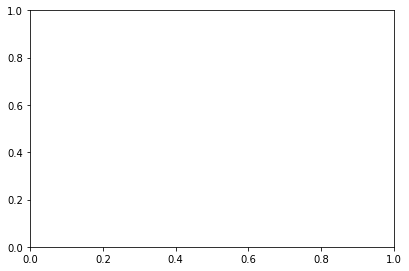

In [51]:
from pandas.tseries import converter
converter.register()

fig = plt.figure(figsize = [15,10])
plt.subplots_adjust(wspace=0.3, hspace=0.3)

ax1 = fig.add_subplot(2,2,1)
ax1.scatter('date', 'weighted_polarity', data=tweets[tweets['biden_only']=='1'], c="green")
ax1.set_title('Biden', color="green")
ax1.set_ylabel("Weighted Polarity of Tweets", position=(0,-0.2))


ax2 = fig.add_subplot(2,2,2)
ax2.scatter('next month polls', 'weighted_polarity', data=tweets_predict[tweets_predict['candidate']=='Warren'], c="orange")
ax2.set_title('Warren', color="orange")


ax3 = fig.add_subplot(2,2,3)
ax3.scatter('next month polls', 'weighted_polarity', data=tweets_predict[tweets_predict['candidate']=='Buttigieg'], c="brown")
ax3.set_title('Buttigieg', color="brown")


ax4 = fig.add_subplot(2,2,4)
ax4.scatter('next month polls', 'weighted_polarity', data=tweets_predict[tweets_predict['candidate']=='Sanders'], c="blue")
ax4.set_title('Sanders', color="blue")

ax4.set_xlabel("Following Month's Polls", position=(-0.1,0))

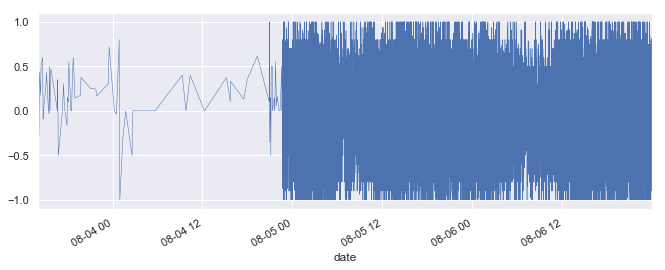

In [93]:
#sns.lineplot(x='date', y='weighted_polarity', data=tweets[tweets['biden_only']=='1'])
tweets = tweets.set_index(tweets['date'])
sns.set(rc={'figure.figsize':(11, 4)})
tweets[tweets.warren_only==1].loc['2019-08-01':'2019-08-07', 'polarity'].plot(linewidth=0.5)
#print(tweets[tweets.warren_only==1].loc['2019-08-02':'2019-08-06'])

## Rate of Tweets per Hour

In [123]:
print('Warren May Daily Rates: ',
      int(len(tweets[tweets.warren_only==1].loc['2019-05-01 00:00:00':'2019-05-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-05-02 00:00:00':'2019-05-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-05-03 00:00:00':'2019-05-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-05-04 00:00:00':'2019-05-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.warren_only==1].loc['2019-05-05 00:00:00':'2019-05-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.warren_only==1].loc['2019-05-06 00:00:00':'2019-05-07 00:00:00', 'polarity'])/24))

print('Biden May Daily Rates: ',
      int(len(tweets[tweets.biden_only==1].loc['2019-05-01 00:00:00':'2019-05-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.biden_only==1].loc['2019-05-02 00:00:00':'2019-05-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.biden_only==1].loc['2019-05-03 00:00:00':'2019-05-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.biden_only==1].loc['2019-05-04 00:00:00':'2019-05-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.biden_only==1].loc['2019-05-05 00:00:00':'2019-05-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.biden_only==1].loc['2019-05-06 00:00:00':'2019-05-07 00:00:00', 'polarity'])/24))

print('Sanders May Daily Rates: ',
      int(len(tweets[tweets.sanders_only==1].loc['2019-05-01 00:00:00':'2019-05-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.sanders_only==1].loc['2019-05-02 00:00:00':'2019-05-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.sanders_only==1].loc['2019-05-03 00:00:00':'2019-05-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.sanders_only==1].loc['2019-05-04 00:00:00':'2019-05-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.sanders_only==1].loc['2019-05-05 00:00:00':'2019-05-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.sanders_only==1].loc['2019-05-06 00:00:00':'2019-05-07 00:00:00', 'polarity'])/24))

print('Buttigieg May Daily Rates',
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-05-01 00:00:00':'2019-05-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-05-02 00:00:00':'2019-05-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-05-03 00:00:00':'2019-05-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-05-04 00:00:00':'2019-05-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-05-05 00:00:00':'2019-05-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-05-06 00:00:00':'2019-05-07 00:00:00', 'polarity'])/24))

print('Warren June Daily Rates: ',
      int(len(tweets[tweets.warren_only==1].loc['2019-06-01 00:00:00':'2019-06-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-06-02 00:00:00':'2019-06-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-06-03 00:00:00':'2019-06-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-06-04 00:00:00':'2019-06-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.warren_only==1].loc['2019-06-05 00:00:00':'2019-06-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.warren_only==1].loc['2019-06-06 00:00:00':'2019-06-07 00:00:00', 'polarity'])/24))

print('Biden June Daily Rates: ',
      int(len(tweets[tweets.biden_only==1].loc['2019-06-01 00:00:00':'2019-06-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.biden_only==1].loc['2019-06-02 00:00:00':'2019-06-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.biden_only==1].loc['2019-06-03 00:00:00':'2019-06-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.biden_only==1].loc['2019-06-04 00:00:00':'2019-06-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.biden_only==1].loc['2019-06-05 00:00:00':'2019-06-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.biden_only==1].loc['2019-06-06 00:00:00':'2019-06-07 00:00:00', 'polarity'])/24))

print('Sanders June Daily Rates: ',
      int(len(tweets[tweets.sanders_only==1].loc['2019-06-01 00:00:00':'2019-06-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.sanders_only==1].loc['2019-06-02 00:00:00':'2019-06-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.sanders_only==1].loc['2019-06-03 00:00:00':'2019-06-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.sanders_only==1].loc['2019-06-04 00:00:00':'2019-06-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.sanders_only==1].loc['2019-06-05 00:00:00':'2019-06-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.sanders_only==1].loc['2019-06-06 00:00:00':'2019-06-07 00:00:00', 'polarity'])/24))

print('Buttigieg June Daily Rates',
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-06-01 00:00:00':'2019-06-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-06-02 00:00:00':'2019-06-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-06-03 00:00:00':'2019-06-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-06-04 00:00:00':'2019-06-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-06-05 00:00:00':'2019-06-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-06-06 00:00:00':'2019-06-07 00:00:00', 'polarity'])/24))

print('Warren July Daily Rates: ',
      int(len(tweets[tweets.warren_only==1].loc['2019-07-01 00:00:00':'2019-07-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-07-02 00:00:00':'2019-07-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-07-03 00:00:00':'2019-07-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-07-04 00:00:00':'2019-07-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.warren_only==1].loc['2019-07-05 00:00:00':'2019-07-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.warren_only==1].loc['2019-07-06 00:00:00':'2019-07-07 00:00:00', 'polarity'])/24))

print('Biden July Daily Rates: ',
      int(len(tweets[tweets.biden_only==1].loc['2019-07-01 00:00:00':'2019-07-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.biden_only==1].loc['2019-07-02 00:00:00':'2019-07-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.biden_only==1].loc['2019-07-03 00:00:00':'2019-07-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.biden_only==1].loc['2019-07-04 00:00:00':'2019-07-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.biden_only==1].loc['2019-07-05 00:00:00':'2019-07-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.biden_only==1].loc['2019-07-06 00:00:00':'2019-07-07 00:00:00', 'polarity'])/24))

print('Sanders July Daily Rates: ',
      int(len(tweets[tweets.sanders_only==1].loc['2019-07-01 00:00:00':'2019-07-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.sanders_only==1].loc['2019-07-02 00:00:00':'2019-07-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.sanders_only==1].loc['2019-07-03 00:00:00':'2019-07-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.sanders_only==1].loc['2019-07-04 00:00:00':'2019-07-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.sanders_only==1].loc['2019-07-05 00:00:00':'2019-07-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.sanders_only==1].loc['2019-07-06 00:00:00':'2019-07-07 00:00:00', 'polarity'])/24))

print('Buttigieg July Daily Rates',
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-07-01 00:00:00':'2019-07-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-07-02 00:00:00':'2019-07-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-07-03 00:00:00':'2019-07-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-07-04 00:00:00':'2019-07-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-07-05 00:00:00':'2019-07-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-07-06 00:00:00':'2019-07-07 00:00:00', 'polarity'])/24))

print('Warren Aug Daily Rates: ',
      int(len(tweets[tweets.warren_only==1].loc['2019-08-01 00:00:00':'2019-08-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-08-02 00:00:00':'2019-08-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-08-03 00:00:00':'2019-08-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-08-04 00:00:00':'2019-08-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.warren_only==1].loc['2019-08-05 00:00:00':'2019-08-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.warren_only==1].loc['2019-08-06 00:00:00':'2019-08-07 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-08-07 00:00:00':'2019-08-08 00:00:00', 'polarity'])/24))

print('Biden Aug Daily Rates: ',
      int(len(tweets[tweets.biden_only==1].loc['2019-08-01 00:00:00':'2019-08-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.biden_only==1].loc['2019-08-02 00:00:00':'2019-08-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.biden_only==1].loc['2019-08-03 00:00:00':'2019-08-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.biden_only==1].loc['2019-08-04 00:00:00':'2019-08-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.biden_only==1].loc['2019-08-05 00:00:00':'2019-08-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.biden_only==1].loc['2019-08-06 00:00:00':'2019-08-07 00:00:00', 'polarity'])/24))

print('Sanders Aug Daily Rates: ',
      int(len(tweets[tweets.sanders_only==1].loc['2019-08-01 00:00:00':'2019-08-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.sanders_only==1].loc['2019-08-02 00:00:00':'2019-08-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.sanders_only==1].loc['2019-08-03 00:00:00':'2019-08-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.sanders_only==1].loc['2019-08-04 00:00:00':'2019-08-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.sanders_only==1].loc['2019-08-05 00:00:00':'2019-08-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.sanders_only==1].loc['2019-08-06 00:00:00':'2019-08-07 00:00:00', 'polarity'])/24))

print('Buttigieg Aug Daily Rates',
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-08-01 00:00:00':'2019-08-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-08-02 00:00:00':'2019-08-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-08-03 00:00:00':'2019-08-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-08-04 00:00:00':'2019-08-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-08-05 00:00:00':'2019-08-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-08-06 00:00:00':'2019-08-07 00:00:00', 'polarity'])/24))

print('Warren Sept Daily Rates: ',
      int(len(tweets[tweets.warren_only==1].loc['2019-09-01 00:00:00':'2019-09-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-09-02 00:00:00':'2019-09-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-09-03 00:00:00':'2019-09-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-09-04 00:00:00':'2019-09-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.warren_only==1].loc['2019-09-05 00:00:00':'2019-09-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.warren_only==1].loc['2019-09-06 00:00:00':'2019-09-07 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.warren_only==1].loc['2019-09-07 00:00:00':'2019-09-08 00:00:00', 'polarity'])/24))

print('Biden Sept Daily Rates: ',
      int(len(tweets[tweets.biden_only==1].loc['2019-09-01 00:00:00':'2019-09-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.biden_only==1].loc['2019-09-02 00:00:00':'2019-09-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.biden_only==1].loc['2019-09-03 00:00:00':'2019-09-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.biden_only==1].loc['2019-09-04 00:00:00':'2019-09-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.biden_only==1].loc['2019-09-05 00:00:00':'2019-09-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.biden_only==1].loc['2019-09-06 00:00:00':'2019-09-07 00:00:00', 'polarity'])/24))

print('Sanders Sept Daily Rates: ',
      int(len(tweets[tweets.sanders_only==1].loc['2019-09-01 00:00:00':'2019-09-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.sanders_only==1].loc['2019-09-02 00:00:00':'2019-09-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.sanders_only==1].loc['2019-09-03 00:00:00':'2019-09-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.sanders_only==1].loc['2019-09-04 00:00:00':'2019-09-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.sanders_only==1].loc['2019-09-05 00:00:00':'2019-09-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.sanders_only==1].loc['2019-09-06 00:00:00':'2019-09-07 00:00:00', 'polarity'])/24))

print('Buttigieg Sept Daily Rates',
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-09-01 00:00:00':'2019-09-02 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-09-02 00:00:00':'2019-09-03 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-09-03 00:00:00':'2019-09-04 00:00:00', 'polarity'])/24),
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-09-04 00:00:00':'2019-09-05 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-09-05 00:00:00':'2019-09-06 00:00:00', 'polarity'])/24), 
      int(len(tweets[tweets.buttigieg_only==1].loc['2019-09-06 00:00:00':'2019-09-07 00:00:00', 'polarity'])/24))

Warren May Daily Rates:  549 576 665 602 458 465
Biden May Daily Rates:  2 1 8 6 7 981
Sanders May Daily Rates:  1 0 457 378 550 457
Buttigieg May Daily Rates 284 260 220 208 219 174
Warren June Daily Rates:  62 580 523 595 597 1061
Biden June Daily Rates:  0 1 11 12 11 887
Sanders June Daily Rates:  0 0 450 416 671 425
Buttigieg June Daily Rates 154 100 158 276 144 94
Warren July Daily Rates:  559 973 605 389 385 389
Biden July Daily Rates:  3 2 8 311 1395 1512
Sanders July Daily Rates:  1 64 438 286 441 813
Buttigieg July Daily Rates 274 218 284 223 127 115
Warren Aug Daily Rates:  0 0 2 85 1763 1381 0
Biden Aug Daily Rates:  0 0 493 524 999 1091
Sanders Aug Daily Rates:  0 0 1 1 952 1012
Buttigieg Aug Daily Rates 179 86 54 154 56 68
Warren Sept Daily Rates:  0 456 526 615 897 605 0
Biden Sept Daily Rates:  0 0 0 353 1620 1073
Sanders Sept Daily Rates:  0 0 0 2 929 1001
Buttigieg Sept Daily Rates 26 31 47 67 168 149


## Donations Data

In [230]:
donations = pd.read_csv('merged_donations.csv')

In [231]:
donations.dtypes

candidate                       object
contributor_name                object
contributor_first_name          object
contributor_last_name           object
contributor_city                object
contributor_state               object
contributor_employer            object
contributor_occupation          object
contribution_receipt_date       object
contribution_receipt_amount    float64
contributor_aggregate_ytd      float64
is_individual                   object
dtype: object

In [232]:
donations['candidate'].unique()

array(['BIDEN FOR PRESIDENT', 'PETE FOR AMERICA, INC.', 'BERNIE 2020',
       'WARREN FOR PRESIDENT, INC.'], dtype=object)

In [233]:
donations['date'] = pd.to_datetime(donations['contribution_receipt_date'])
donations['month'] = donations['date'].dt.month

df = pd.DataFrame()
df['donation_amount'] = donations.groupby(['candidate', 'month'])['contribution_receipt_amount'].sum()

In [234]:
donations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229878 entries, 0 to 229877
Data columns (total 14 columns):
candidate                      229878 non-null object
contributor_name               229878 non-null object
contributor_first_name         124475 non-null object
contributor_last_name          124473 non-null object
contributor_city               229827 non-null object
contributor_state              229829 non-null object
contributor_employer           123716 non-null object
contributor_occupation         229185 non-null object
contribution_receipt_date      229878 non-null object
contribution_receipt_amount    229878 non-null float64
contributor_aggregate_ytd      229878 non-null float64
is_individual                  229878 non-null object
date                           229878 non-null datetime64[ns]
month                          229878 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(10)
memory usage: 24.6+ MB


In [236]:
print(df)

                                  donation_amount
candidate                  month                 
BERNIE 2020                5            330518.42
                           6            553284.34
                           7            558934.63
                           8            864090.65
                           9           1255163.04
BIDEN FOR PRESIDENT        5           2454132.88
                           6            846584.10
                           7            383348.73
                           8           1082551.86
                           9            925495.19
PETE FOR AMERICA, INC.     5           2330205.16
                           6           1110198.97
                           7           1446525.76
                           8           1070489.19
                           9           1366999.78
WARREN FOR PRESIDENT, INC. 5            596982.85
                           6            768652.75
                           7            763597.10


,month weighted_polarity,candidate,next_month_polls,polarity,weighted_polarity,num_tweets,replies,retweets,favorites,num_reactions,donations,tweets_per_hr
0,2019-08,Biden,29.961290,0.023266,0.023192,74600,76438,192416,607132,875986,1082551.86,1091
1,2019-07,Biden,27.539286,0.041293,0.098450,77624,186661,295535,1082369,1564565,383348.73,1512
2,2019-06,Biden,23.805882,0.039818,0.046036,22206,22950,50355,165547,238852,846584.10,887
3,2019-05,Biden,29.701538,0.043252,0.057450,24184,30535,105700,279136,415371,330518.42,981
4,2019-09,Biden,19.735789,0.042600,0.071477,73148,101301,244180,807384,1152865,925495.19,1620
5,2019-08,Buttigieg,4.862069,0.057942,0.086019,14365,17862,58017,228395,304274,1070489.19,179
6,2019-07,Buttigieg,5.228571,0.097435,0.208329,29848,39641,132635,582497,754773,1446525.76,284
7,2019-06,Buttigieg,7.088235,0.091758,0.188690,22274,36763,107286,468265,612314,1110198.97,276
8,2019-05,Buttigieg,8.283077,0.107115,0.252060,32835,57222,126010,749617,932849,2330205.16,284
9,2019-09,Buttigieg,15.989362,0.058300,0.124856,11768,49643,96978,326665,473286,1366999.78,168


In [4]:
scaled_data = tweets_predict.copy()

scaled_data['next_month_polls'] = (tweets_predict.next_month_polls-tweets_predict.next_month_polls.mean())/tweets_predict.next_month_polls.std()
scaled_data['polarity'] = (tweets_predict.polarity-tweets_predict.polarity.mean())/tweets_predict.polarity.std()
scaled_data['weighted_polarity'] = (tweets_predict.weighted_polarity-tweets_predict.weighted_polarity.mean())/tweets_predict.weighted_polarity.std()
scaled_data['num_tweets'] = (tweets_predict.num_tweets-tweets_predict.num_tweets.mean())/tweets_predict.num_tweets.std()
scaled_data['replies'] = (tweets_predict.replies-tweets_predict.replies.mean())/tweets_predict.replies.std()
scaled_data['retweets'] = (tweets_predict.retweets-tweets_predict.retweets.mean())/tweets_predict.retweets.std()
scaled_data['favorites'] = (tweets_predict.favorites-tweets_predict.favorites.mean())/tweets_predict.favorites.std()
scaled_data['num_reactions'] = (tweets_predict.num_reactions-tweets_predict.num_reactions.mean())/tweets_predict.num_reactions.std()
scaled_data['donations'] = (tweets_predict.donations-tweets_predict.donations.mean())/tweets_predict.donations.std()
scaled_data['tweets_per_hr'] = (tweets_predict.tweets_per_hr-tweets_predict.tweets_per_hr.mean())/tweets_predict.tweets_per_hr.std()
scaled_data.head(20)

,month weighted_polarity,candidate,next_month_polls,polarity,weighted_polarity,num_tweets,replies,retweets,favorites,num_reactions,donations,tweets_per_hr
0,2019-08,Biden,1.733957,-1.276074,-1.206421,0.970157,0.461357,0.422312,0.041584,0.163567,0.233386,0.553022
1,2019-07,Biden,1.409737,-0.666243,-0.063359,1.091903,3.353661,1.628816,1.660846,1.873144,-1.253424,1.460358
2,2019-06,Biden,0.909968,-0.716131,-0.859453,-1.139216,-0.942193,-1.239816,-1.463018,-1.418285,-0.268384,0.113363
3,2019-05,Biden,1.699186,-0.599975,-0.686094,-1.059582,-0.743159,-0.592274,-1.075989,-0.980030,-1.365765,0.315951
4,2019-09,Biden,0.365128,-0.622017,-0.473038,0.911700,1.113774,1.027957,0.723897,0.850991,-0.100585,1.693119
5,2019-08,Buttigieg,-1.625931,-0.103028,-0.252177,-1.454894,-1.075705,-1.150170,-1.248877,-1.255858,0.207735,-1.412513
6,2019-07,Buttigieg,-1.576869,1.232908,1.605534,-0.831551,-0.504213,-0.277132,-0.042355,-0.137376,1.007353,-1.186218
7,2019-06,Buttigieg,-1.327927,1.040884,1.307255,-1.136479,-0.579733,-0.573718,-0.431574,-0.491068,0.292175,-1.203459
8,2019-05,Buttigieg,-1.167980,1.560391,2.269748,-0.711295,-0.042880,-0.354645,0.527069,0.304744,2.886439,-1.186218
9,2019-09,Buttigieg,-0.136384,-0.090942,0.337711,-1.559449,-0.241756,-0.694322,-0.914044,-0.836241,0.838246,-1.436220


## Graphs and Visualizations

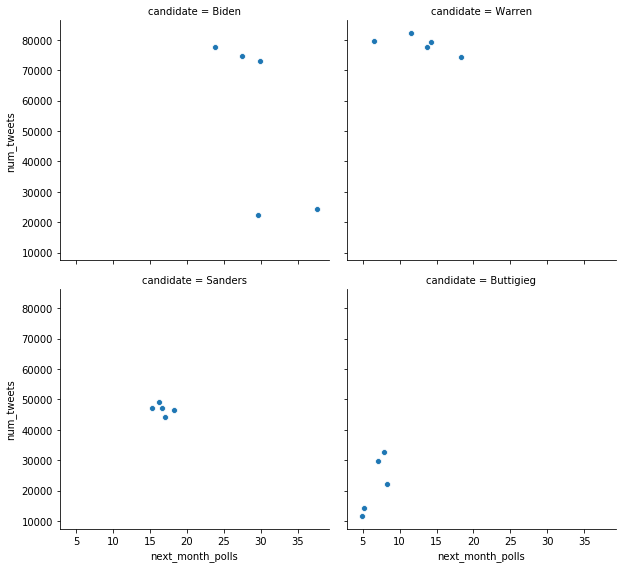

In [327]:
# Number of Tweets vs. Next Month Polls

#plt.figure(figsize = [10,20])
sns.relplot(x='next_month_polls', y='num_tweets', data=tweets_predict, col='candidate', 
            col_wrap=2, height=4, aspect=1.1)
#p.figure.set_size_inches(18.5, 10.5)
sns.despine()

Text(-0.1, 0, "Next Month's Polls")

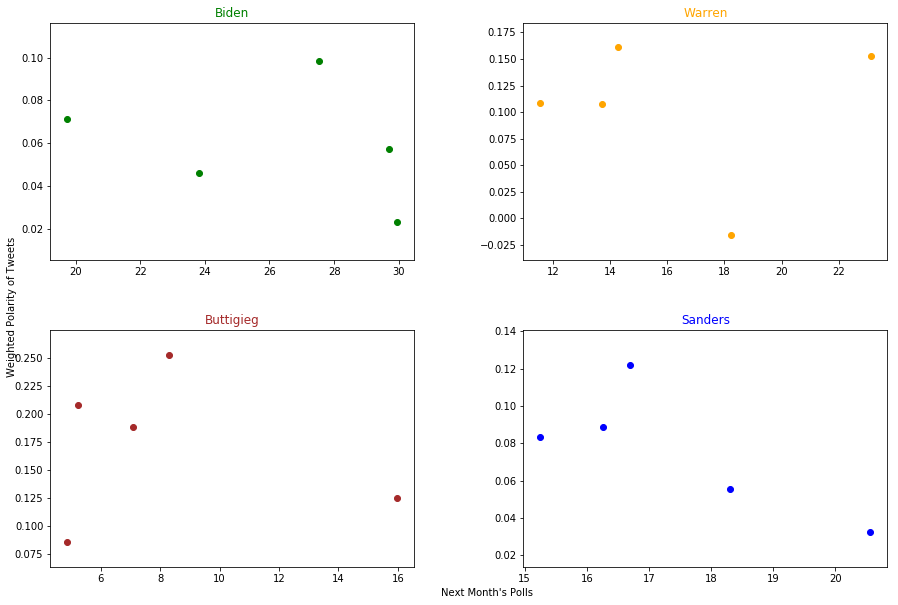

In [6]:
# Weighted Polarity of Tweets vs. Next Month Polls

from matplotlib.pyplot import title

fig = plt.figure(figsize = [15,10])
plt.subplots_adjust(wspace=0.3, hspace=0.3)

ax1 = fig.add_subplot(2,2,1)
ax1.scatter('next_month_polls', 'weighted_polarity', data=tweets_predict[tweets_predict['candidate']=='Biden'], c="green")
ax1.set_title('Biden', color="green")
ax1.set_ylabel("Weighted Polarity of Tweets", position=(0,-0.2))


ax2 = fig.add_subplot(2,2,2)
ax2.scatter('next_month_polls', 'weighted_polarity', data=tweets_predict[tweets_predict['candidate']=='Warren'], c="orange")
ax2.set_title('Warren', color="orange")


ax3 = fig.add_subplot(2,2,3)
ax3.scatter('next_month_polls', 'weighted_polarity', data=tweets_predict[tweets_predict['candidate']=='Buttigieg'], c="brown")
ax3.set_title('Buttigieg', color="brown")


ax4 = fig.add_subplot(2,2,4)
ax4.scatter('next_month_polls', 'weighted_polarity', data=tweets_predict[tweets_predict['candidate']=='Sanders'], c="blue")
ax4.set_title('Sanders', color="blue")

ax4.set_xlabel("Next Month's Polls", position=(-0.1,0))

Text(-0.1, 0, "Following Month's Polls")

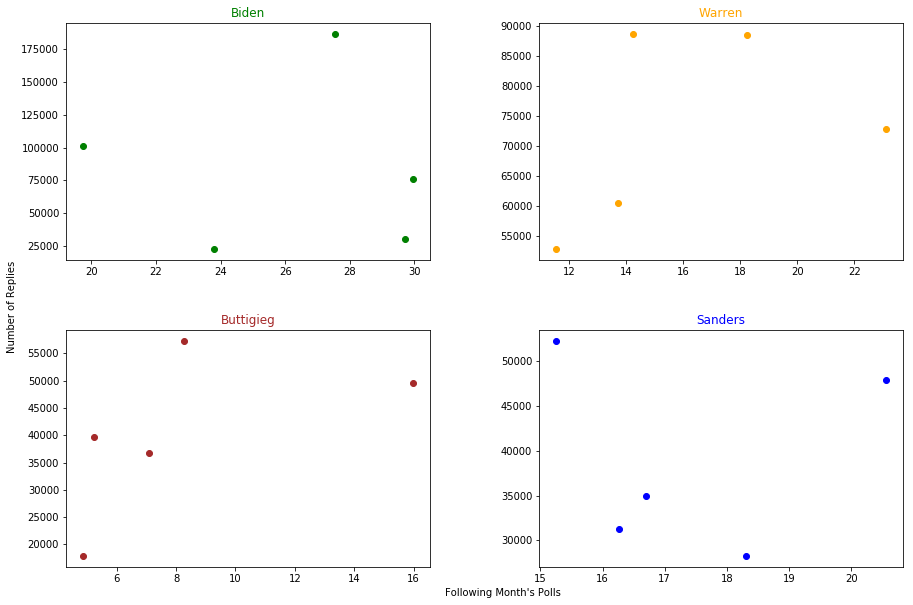

In [7]:
fig = plt.figure(figsize = [15,10])

plt.subplots_adjust(wspace=0.3, hspace=0.3)

ax1 = fig.add_subplot(2,2,1)
ax1.scatter('next_month_polls', 'replies', data=tweets_predict[tweets_predict['candidate']=='Biden'], c="green")
ax1.set_title('Biden', color="green")
ax1.set_ylabel("Number of Replies", position=(0,-0.2))


ax2 = fig.add_subplot(2,2,2)
ax2.scatter('next_month_polls', 'replies', data=tweets_predict[tweets_predict['candidate']=='Warren'], c="orange")
ax2.set_title('Warren', color="orange")


ax3 = fig.add_subplot(2,2,3)
ax3.scatter('next_month_polls', 'replies', data=tweets_predict[tweets_predict['candidate']=='Buttigieg'], c="brown")
ax3.set_title('Buttigieg', color="brown")


ax4 = fig.add_subplot(2,2,4)
ax4.scatter('next_month_polls', 'replies', data=tweets_predict[tweets_predict['candidate']=='Sanders'], c="blue")
ax4.set_title('Sanders', color="blue")

ax4.set_xlabel("Following Month's Polls",  position=(-0.1,0))

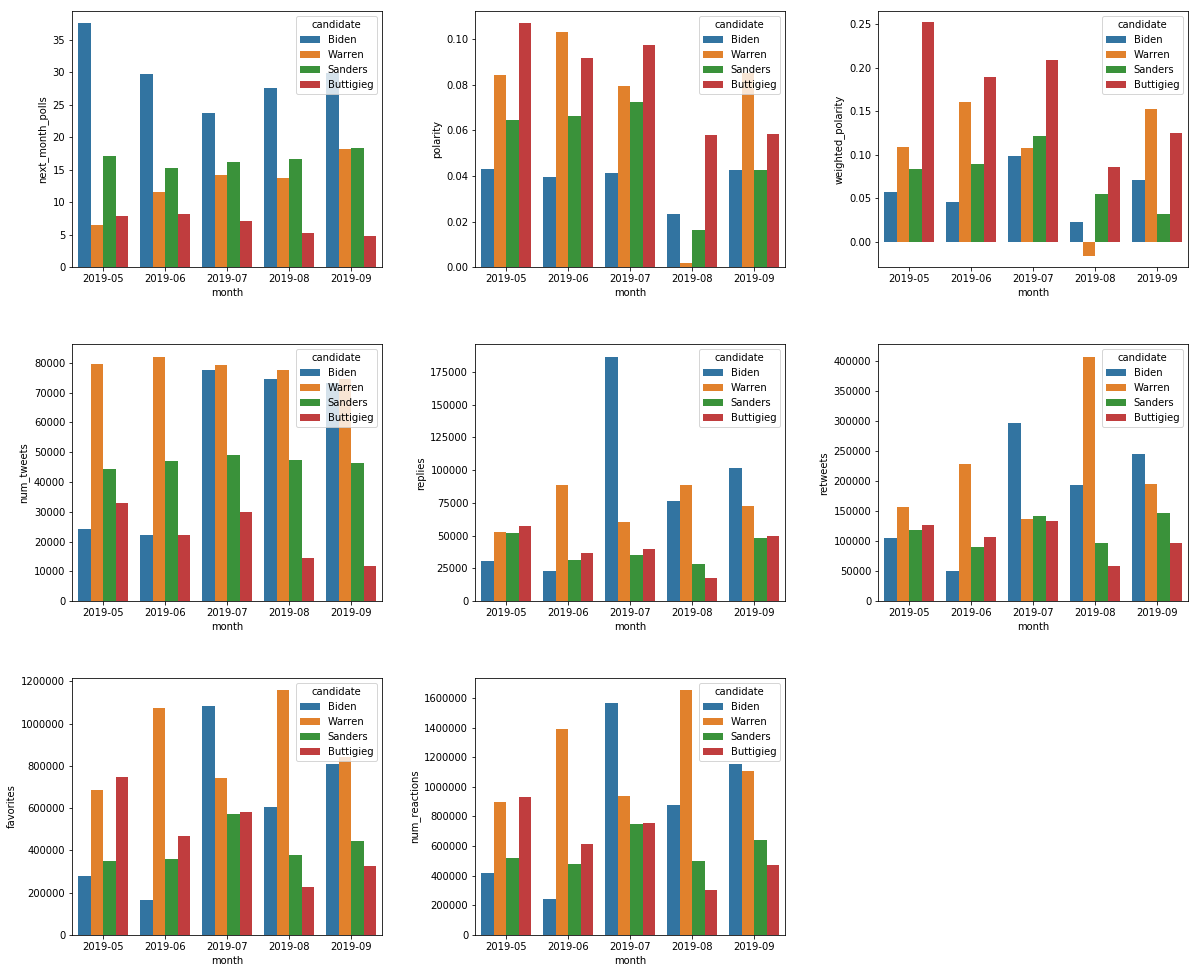

In [330]:
fig = plt.figure(figsize = [20, 17])
fig.subplots_adjust(hspace=0.3, wspace=0.3)

ax = fig.add_subplot(3, 3, 1)
sns.barplot(x="month", y="next_month_polls", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

ax = fig.add_subplot(3, 3, 2)
sns.barplot(x="month", y="polarity", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

ax = fig.add_subplot(3, 3, 3)
sns.barplot(x="month", y="weighted_polarity", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

ax = fig.add_subplot(3, 3, 4)
sns.barplot(x="month", y="num_tweets", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

ax = fig.add_subplot(3, 3, 5)
sns.barplot(x="month", y="replies", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

ax = fig.add_subplot(3, 3, 6)
sns.barplot(x="month", y="retweets", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

ax = fig.add_subplot(3, 3, 7)
sns.barplot(x="month", y="favorites", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

ax = fig.add_subplot(3, 3, 8)
sns.barplot(x="month", y="num_reactions", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

plt.show()

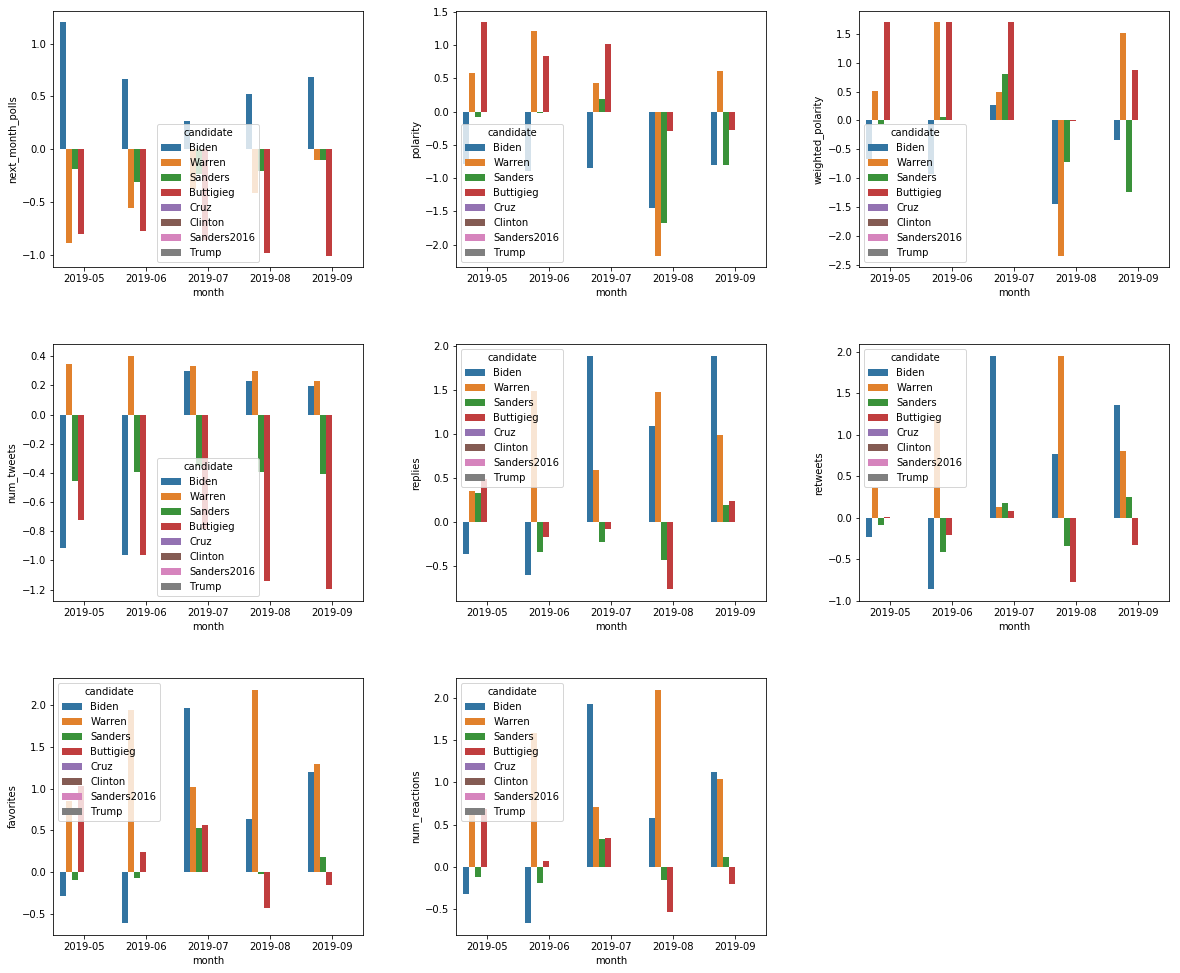

In [331]:
fig = plt.figure(figsize = [20, 17])
fig.subplots_adjust(hspace=0.3, wspace=0.3)


ax = fig.add_subplot(3, 3, 1)
sns.barplot(x="month", y="next_month_polls", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=scaled_data)

ax = fig.add_subplot(3, 3, 2)
sns.barplot(x="month", y="polarity", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=scaled_data)

ax = fig.add_subplot(3, 3, 3)
sns.barplot(x="month", y="weighted_polarity", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=scaled_data)

ax = fig.add_subplot(3, 3, 4)
sns.barplot(x="month", y="num_tweets", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=scaled_data)

ax = fig.add_subplot(3, 3, 5)
sns.barplot(x="month", y="replies", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=scaled_data)

ax = fig.add_subplot(3, 3, 6)
sns.barplot(x="month", y="retweets", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=scaled_data)

ax = fig.add_subplot(3, 3, 7)
sns.barplot(x="month", y="favorites", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=scaled_data)

ax = fig.add_subplot(3, 3, 8)
sns.barplot(x="month", y="num_reactions", hue='candidate', order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=scaled_data)

plt.show()

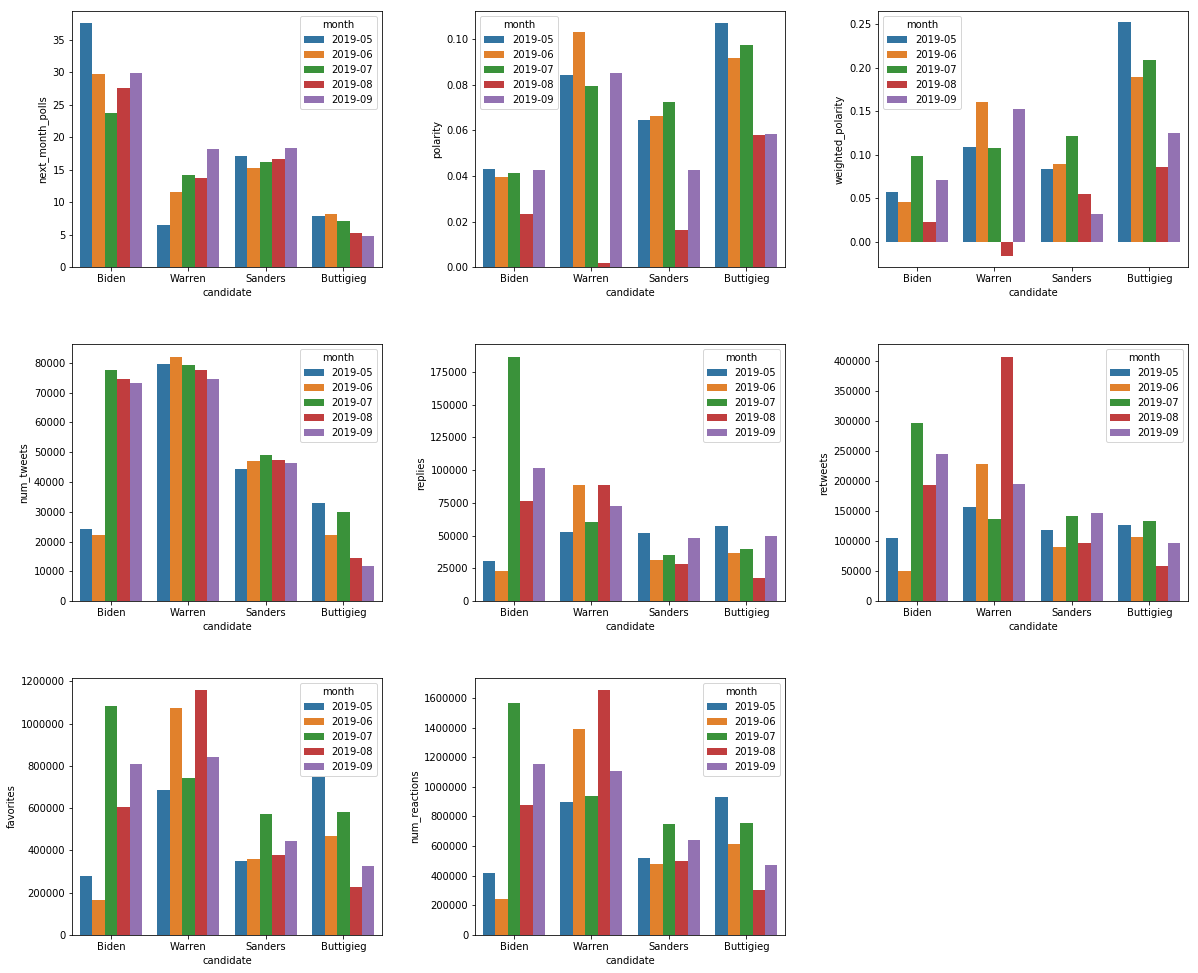

In [333]:
fig = plt.figure(figsize = [20, 17])
fig.subplots_adjust(hspace=0.3, wspace=0.3)


ax = fig.add_subplot(3, 3, 1)
sns.barplot(x="candidate", y="next_month_polls", hue='month', hue_order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

ax = fig.add_subplot(3, 3, 2)
sns.barplot(x="candidate", y="polarity", hue='month', hue_order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

ax = fig.add_subplot(3, 3, 3)
sns.barplot(x="candidate", y="weighted_polarity", hue='month', hue_order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

ax = fig.add_subplot(3, 3, 4)
sns.barplot(x="candidate", y="num_tweets", hue='month', hue_order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

ax = fig.add_subplot(3, 3, 5)
sns.barplot(x="candidate", y="replies", hue='month', hue_order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

ax = fig.add_subplot(3, 3, 6)
sns.barplot(x="candidate", y="retweets", hue='month', hue_order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

ax = fig.add_subplot(3, 3, 7)
sns.barplot(x="candidate", y="favorites", hue='month', hue_order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

ax = fig.add_subplot(3, 3, 8)
sns.barplot(x="candidate", y="num_reactions", hue='month', hue_order=['2019-05', '2019-06', '2019-07', '2019-08', '2019-09'], data=tweets_predict)

plt.show()

## Load 2015 Tweets

In [13]:
import pandas as pd
sanders_tweets2016 = pd.read_csv('sanders_merged.csv', encoding='ISO-8859-1', parse_dates=['date'], dtype={'place': object})

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (0,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
len(sanders_tweets2016.index)

308739

In [14]:
cruz_tweets2016 = pd.read_csv('cruz_merged.csv', encoding='ISO-8859-1', parse_dates=['date'])

In [4]:
len(cruz_tweets2016.index)

170521

In [15]:
clinton_tweets2016 = pd.read_csv('clinton_merged.csv', encoding='ISO-8859-1', parse_dates=['date'])

In [26]:
len(clinton_tweets2016.index)

776150

In [16]:
trump_tweets2016 = pd.read_csv('trump_merged.csv', encoding='ISO-8859-1', parse_dates=['date'])

In [17]:
trump2_tweets2016 = pd.read_csv('trump2_merged.csv', encoding='ISO-8859-1', parse_dates=['date'])

In [18]:
trump_tweets2016 = pd.concat([trump_tweets2016, trump2_tweets2016], sort=True)

In [198]:
len(trump_tweets2016.index)

1604440

In [19]:
from textblob import TextBlob 

def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

cruz_tweets2016['sentiment'] = cruz_tweets2016['tweet'].apply(sentiment_calc)

def polarity_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

cruz_tweets2016['polarity'] = cruz_tweets2016['tweet'].apply(polarity_calc)

def subjectivity_calc(text):
    try:
        return TextBlob(text).sentiment.subjectivity
    except:
        return None

cruz_tweets2016['subjectivity'] = cruz_tweets2016['tweet'].apply(subjectivity_calc)

In [85]:
#cruz_tweets2016.to_csv(r'cruz_with_sentiment.csv')
cruz_tweets2016['replies_count'] = cruz_tweets2016.replies_count.convert_objects(convert_numeric=True)
cruz_tweets2016['retweets_count'] = cruz_tweets2016.retweets_count.convert_objects(convert_numeric=True)
cruz_tweets2016['likes_count'] = cruz_tweets2016.likes_count.convert_objects(convert_numeric=True)
cruz_tweets2016['reactions'] = cruz_tweets2016['replies_count'] + cruz_tweets2016['retweets_count'] + cruz_tweets2016['likes_count']
cruz_tweets2016['weighted_polarity'] = ((cruz_tweets2016['reactions']/30) + 1) * cruz_tweets2016['polarity']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversi

In [20]:
sanders_tweets2016['sentiment'] = sanders_tweets2016['tweet'].apply(sentiment_calc)
sanders_tweets2016['polarity'] = sanders_tweets2016['tweet'].apply(polarity_calc)
sanders_tweets2016['subjectivity'] = sanders_tweets2016['tweet'].apply(subjectivity_calc)

In [84]:
#sanders_tweets2016.to_csv(r'sanders_with_sentiment.csv')
sanders_tweets2016['replies_count'] = sanders_tweets2016.replies_count.convert_objects(convert_numeric=True)
sanders_tweets2016['retweets_count'] = sanders_tweets2016.retweets_count.convert_objects(convert_numeric=True)
sanders_tweets2016['likes_count'] = sanders_tweets2016.likes_count.convert_objects(convert_numeric=True)
sanders_tweets2016['reactions'] = sanders_tweets2016['replies_count'] + sanders_tweets2016['retweets_count'] + sanders_tweets2016['likes_count']
sanders_tweets2016['weighted_polarity'] = ((sanders_tweets2016['reactions']/30) + 1) * sanders_tweets2016['polarity']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversi

In [21]:
clinton_tweets2016['sentiment'] = clinton_tweets2016['tweet'].apply(sentiment_calc)
clinton_tweets2016['polarity'] = clinton_tweets2016['tweet'].apply(polarity_calc)
clinton_tweets2016['subjectivity'] = clinton_tweets2016['tweet'].apply(subjectivity_calc)

In [83]:
#clinton_tweets2016.to_csv(r'clinton_with_sentiment.csv')
clinton_tweets2016['replies_count'] = clinton_tweets2016.replies_count.convert_objects(convert_numeric=True)
clinton_tweets2016['retweets_count'] = clinton_tweets2016.retweets_count.convert_objects(convert_numeric=True)
clinton_tweets2016['likes_count'] = clinton_tweets2016.likes_count.convert_objects(convert_numeric=True)
clinton_tweets2016['reactions'] = clinton_tweets2016['replies_count'] + clinton_tweets2016['retweets_count'] + clinton_tweets2016['likes_count']
clinton_tweets2016['weighted_polarity'] = ((clinton_tweets2016['reactions']/30) + 1) * clinton_tweets2016['polarity']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversi

In [22]:
trump_tweets2016['sentiment'] = trump_tweets2016['tweet'].apply(sentiment_calc)
trump_tweets2016['polarity'] = trump_tweets2016['tweet'].apply(polarity_calc)
trump_tweets2016['subjectivity'] = trump_tweets2016['tweet'].apply(subjectivity_calc)

In [82]:
#trump_tweets2016.to_csv(r'trump_with_sentiment.csv')
trump_tweets2016['replies_count'] = trump_tweets2016.replies_count.convert_objects(convert_numeric=True)
trump_tweets2016['retweets_count'] = trump_tweets2016.retweets_count.convert_objects(convert_numeric=True)
trump_tweets2016['likes_count'] = trump_tweets2016.likes_count.convert_objects(convert_numeric=True)
trump_tweets2016['reactions'] = trump_tweets2016['replies_count'] + trump_tweets2016['retweets_count'] + trump_tweets2016['likes_count']
trump_tweets2016['weighted_polarity'] = ((trump_tweets2016['reactions']/30) + 1) * trump_tweets2016['polarity']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversi

In [86]:
tweets2016 = pd.concat([trump_tweets2016, clinton_tweets2016, sanders_tweets2016, cruz_tweets2016], sort=True)

In [76]:
# tweets2016['replies_count'] = tweets2016.replies_count.convert_objects(convert_numeric=True)
# tweets2016['retweets_count'] = tweets2016.retweets_count.convert_objects(convert_numeric=True)
# tweets2016['likes_count'] = tweets2016.likes_count.convert_objects(convert_numeric=True)
# tweets2016['reactions'] = tweets2016['replies_count'] + tweets2016['retweets_count'] + tweets2016['likes_count']
# tweets2016['weighted_polarity'] = ((tweets2016['reactions']/30) + 1) * tweets2016['polarity']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific c

In [87]:
#tweets2016.to_csv(r'all_tweets_with_sentiment.csv')
tweets2016.head()

,date,hashtags,id,likes_count,mentions,polarity,reactions,replies_count,retweets_count,sentiment,subjectivity,time,tweet,username,weighted_polarity
0,2015-08-06 00:00:00,[],6.29502e+17,0.0,['ac360'],0.1,0.0,0.0,0.0,"(0.1, 1.0)",1.00,23:59:59,@AC360 Is this what it comes to? These clowns ...,80juangarcia,0.1
1,2015-08-06 00:00:00,['#alfinaldeldialasegunda'],6.29502e+17,0.0,[],0.0,0.0,0.0,0.0,"(0.0, 0.0)",0.00,23:59:59,#Alfinaldeldialasegunda åÁTACOS GRATIS! \n\nTa...,crystal1037fm,0.0
2,2015-08-06 00:00:00,[],6.29502e+17,0.0,"['foxandfriends', 'realdonaldtrump', 'realbenc...",1.0,0.0,0.0,0.0,"(1.0, 0.75)",0.75,23:59:59,@foxandfriends @realDonaldTrump and @RealBenC...,tireguyjohn,1.0
3,2015-08-06 00:00:00,[],6.29502e+17,0.0,['drvox'],0.0,0.0,0.0,0.0,"(0.0, 0.0)",0.00,23:59:59,He's where Republicans are RT @drvox: Here are...,mama4obama1,0.0
4,2015-08-06 00:00:00,[],6.29502e+17,0.0,"['gqforbes', 'realdonaldtrump', 'jimlibertarian']",0.0,0.0,0.0,0.0,"(0.0, 0.0)",0.00,23:59:58,@gqforbes @realDonaldTrump @jimlibertarian To ...,oriverway,0.0


In [204]:
tweets2016['date'] = pd.to_datetime(tweets2016['date'], errors='coerce', cache=False)
tweets2016['month'] = tweets2016.date.dt.to_period('M')

In [206]:
cruz_mask = ((tweets2016['tweet'].str.contains('cruz', case=False)) | 
                  (tweets2016['mentions'].str.contains('cruz', case=False)) | 
                  (tweets2016['hashtags'].str.contains('cruz', case=False)))

tweets2016['cruz'] = 0
tweets2016.cruz[cruz_mask] = 1

clinton_mask = ((tweets2016['tweet'].str.contains('clinton', case=False)) | 
                  (tweets2016['mentions'].str.contains('clinton', case=False)) | 
                  (tweets2016['hashtags'].str.contains('clinton', case=False)))

tweets2016['clinton'] = 0
tweets2016.clinton[clinton_mask] = 1

sanders_mask = ((tweets2016['tweet'].str.contains('sanders', case=False)) | 
                  (tweets2016['mentions'].str.contains('sanders', case=False)) | 
                  (tweets2016['hashtags'].str.contains('sanders', case=False)))

tweets2016['sanders'] = 0
tweets2016.sanders[sanders_mask] = 1

trump_mask = ((tweets2016['tweet'].str.contains('trump', case=False)) | 
                  (tweets2016['mentions'].str.contains('trump', case=False)) | 
                  (tweets2016['hashtags'].str.contains('trump', case=False)))

tweets2016['trump'] = 0
tweets2016.trump[trump_mask] = 1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python

In [207]:
cruz_mask_1 = ((tweets2016['cruz'] == 1) & (tweets2016['clinton'] == 0) & 
               (tweets2016['sanders'] == 0) & (tweets2016['trump'] == 0))
tweets2016['cruz_only'] = 0
tweets2016.cruz_only[cruz_mask_1] = 1
cruz_monthly = tweets2016[cruz_mask_1].groupby(['cruz_only', 'month']).polarity.mean()

clinton_mask_1 = ((tweets2016['cruz'] == 0) & (tweets2016['clinton'] == 1) & 
                (tweets2016['sanders'] == 0) & (tweets2016['trump'] == 0))
tweets2016['clinton_only'] = 0
tweets2016.clinton_only[clinton_mask_1] = 1
clinton_monthly = tweets2016[clinton_mask_1].groupby(['clinton_only', 'month']).polarity.mean()


sanders_mask_1 = ((tweets2016['cruz'] == 0) & (tweets2016['clinton'] == 0) & 
                (tweets2016['sanders'] == 1) & (tweets2016['trump'] == 0))
tweets2016['sanders_only'] = 0
tweets2016.sanders_only[sanders_mask_1] = 1
sanders_monthly = tweets2016[sanders_mask_1].groupby(['sanders_only', 'month']).polarity.mean()


trump_mask_1 = ((tweets2016['cruz'] == 0) & (tweets2016['clinton'] == 0) & 
                (tweets2016['sanders'] == 0) & (tweets2016['trump'] == 1))
tweets2016['trump_only'] = 0
tweets2016.trump_only[trump_mask_1] = 1
trump_monthly = tweets2016[trump_mask_1].groupby(['trump_only', 'month']).polarity.mean()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

In [70]:
#tweets2016.to_csv(r'all_tweets_2016.csv')

## 2015 Polling Data

In [209]:
polls2016 = pd.read_csv('polls2015.csv', encoding='ISO-8859-1')
polls2016.set_index('month')

,Cruz Polls,Trump Polls,Clinton Polls,Sanders Polls
month,,,,
2015-05,5.545455,7.666667,58.800000,15.700000
2015-06,5.529412,10.941176,55.761905,19.666667
2015-07,6.111111,1.148148,49.666667,22.750000
2015-08,6.117647,15.437500,43.162500,27.241667
2015-09,6.481481,29.555556,50.608000,26.624000


In [210]:
concat_polarity2016 = pd.concat([cruz_monthly, clinton_monthly, sanders_monthly, trump_monthly], axis = 1)
concat_polarity2016.columns= ["Cruz Polarity", 'Clinton Polarity', 'Sanders Polarity', 'Trump Polarity']
new_index = []
concat_polarity2016.reset_index(level='cruz_only', drop=True, inplace=True)
concat_polarity2016.head()

,Cruz Polarity,Clinton Polarity,Sanders Polarity,Trump Polarity
month,,,,
2015-05,0.059407,0.046869,0.098655,0.072781
2015-06,0.028746,0.052233,0.097940,0.133169
2015-07,0.066467,0.067730,0.089422,0.026432
2015-08,0.059469,0.063260,0.086910,0.054347
2015-09,0.051023,0.046816,0.088695,0.056794


In [211]:
polls_polarity2016 = pd.merge(polls2016, concat_polarity2016, on='month', left_index=True, right_index=True)
polls_polarity2016.head()

,month,Cruz Polls,Trump Polls,Clinton Polls,Sanders Polls,Cruz Polarity,Clinton Polarity,Sanders Polarity,Trump Polarity
0,2015-05,5.545455,7.666667,58.800000,15.700000,0.059407,0.046869,0.098655,0.072781
1,2015-06,5.529412,10.941176,55.761905,19.666667,0.028746,0.052233,0.097940,0.133169
2,2015-07,6.111111,1.148148,49.666667,22.750000,0.066467,0.067730,0.089422,0.026432
3,2015-08,6.117647,15.437500,43.162500,27.241667,0.059469,0.063260,0.086910,0.054347
4,2015-09,6.481481,29.555556,50.608000,26.624000,0.051023,0.046816,0.088695,0.056794


In [212]:
cruz_weightedpol_monthly = tweets2016[cruz_mask_1].groupby(['cruz_only', 'month']).weighted_polarity.mean()
clinton_weightedpol_monthly = tweets2016[clinton_mask_1].groupby(['clinton_only', 'month']).weighted_polarity.mean()
sanders_weightedpol_monthly = tweets2016[sanders_mask_1].groupby(['sanders_only', 'month']).weighted_polarity.mean()
trump_weightedpol_monthly = tweets2016[trump_mask_1].groupby(['trump_only', 'month']).weighted_polarity.mean()


In [213]:
concat_weightedpol2016 = pd.concat([cruz_weightedpol_monthly, clinton_weightedpol_monthly, sanders_weightedpol_monthly, trump_weightedpol_monthly], axis = 1)
concat_weightedpol2016.columns= ["Cruz Weighted Polarity", 'Clinton Weighted Polarity', 'Sanders Weighted Polarity', 'Trump Weighted Polarity']
concat_weightedpol2016.reset_index(level='cruz_only', drop=True, inplace=True)
concat_weightedpol2016.head()

,Cruz Weighted Polarity,Clinton Weighted Polarity,Sanders Weighted Polarity,Trump Weighted Polarity
month,,,,
2015-05,0.065381,0.049533,0.106408,0.079921
2015-06,0.030957,0.055935,0.107635,0.138884
2015-07,0.071220,0.072062,0.097340,0.026898
2015-08,0.069544,0.069133,0.093360,0.058326
2015-09,0.058145,0.041293,0.094488,0.064231


In [214]:
df = pd.merge(polls_polarity2016, concat_weightedpol2016, on='month', left_index=True, right_index=True)
df.head()

,month,Cruz Polls,Trump Polls,Clinton Polls,Sanders Polls,Cruz Polarity,Clinton Polarity,Sanders Polarity,Trump Polarity,Cruz Weighted Polarity,Clinton Weighted Polarity,Sanders Weighted Polarity,Trump Weighted Polarity
0,2015-05,5.545455,7.666667,58.800000,15.700000,0.059407,0.046869,0.098655,0.072781,0.065381,0.049533,0.106408,0.079921
1,2015-06,5.529412,10.941176,55.761905,19.666667,0.028746,0.052233,0.097940,0.133169,0.030957,0.055935,0.107635,0.138884
2,2015-07,6.111111,1.148148,49.666667,22.750000,0.066467,0.067730,0.089422,0.026432,0.071220,0.072062,0.097340,0.026898
3,2015-08,6.117647,15.437500,43.162500,27.241667,0.059469,0.063260,0.086910,0.054347,0.069544,0.069133,0.093360,0.058326
4,2015-09,6.481481,29.555556,50.608000,26.624000,0.051023,0.046816,0.088695,0.056794,0.058145,0.041293,0.094488,0.064231


In [215]:
tweets2016 = tweets2016.rename(columns={"likes_count": "favorites", "replies_count": "replies", "retweets_count":"retweets"})

In [216]:
tweets2016['cruz_replies'] = tweets2016.replies * tweets2016.cruz_only
tweets2016['cruz_retweets'] = tweets2016.retweets * tweets2016.cruz_only
tweets2016['cruz_favorites'] = tweets2016.favorites * tweets2016.cruz_only
cruz_reactions = tweets2016.groupby('month')[['cruz_only', 'cruz_replies', 'cruz_retweets', 'cruz_favorites']].sum()

tweets2016['clinton_replies'] = tweets2016.replies * tweets2016.clinton_only
tweets2016['clinton_retweets'] = tweets2016.retweets * tweets2016.clinton_only
tweets2016['clinton_favorites'] = tweets2016.favorites * tweets2016.clinton_only
clinton_reactions = tweets2016.groupby('month')[['clinton_only', 'clinton_replies', 'clinton_retweets', 'clinton_favorites']].sum()

tweets2016['sanders_replies'] = tweets2016.replies * tweets2016.sanders_only
tweets2016['sanders_retweets'] = tweets2016.retweets * tweets2016.sanders_only
tweets2016['sanders_favorites'] = tweets2016.favorites * tweets2016.sanders_only
sanders_reactions = tweets2016.groupby('month')[['sanders_only', 'sanders_replies', 'sanders_retweets', 'sanders_favorites']].sum()

tweets2016['trump_replies'] = tweets2016.replies * tweets2016.trump_only
tweets2016['trump_retweets'] = tweets2016.retweets * tweets2016.trump_only
tweets2016['trump_favorites'] = tweets2016.favorites * tweets2016.trump_only
trump_reactions = tweets2016.groupby('month')[['trump_only', 'trump_replies', 'trump_retweets', 'trump_favorites']].sum()

concat_reactions2016 = pd.concat([cruz_reactions, clinton_reactions, sanders_reactions, trump_reactions], axis = 1)
concat_reactions2016.head()

,cruz_only,cruz_replies,cruz_retweets,cruz_favorites,clinton_only,clinton_replies,clinton_retweets,clinton_favorites,sanders_only,sanders_replies,sanders_retweets,sanders_favorites,trump_only,trump_replies,trump_retweets,trump_favorites
month,,,,,,,,,,,,,,,,
2015-05,14842,4919.0,18453.0,14129.0,140625,31148.0,109756.0,84088.0,37324,7226.0,35555.0,39490.0,36122,10523.0,24662.0,33703.0
2015-06,22978,8758.0,25012.0,22102.0,137305,34148.0,105951.0,95495.0,36500,7981.0,33474.0,40352.0,30261,8124.0,28583.0,43229.0
2015-07,23437,7609.0,32065.0,26985.0,120607,26175.0,88493.0,89218.0,56020,12676.0,56080.0,74156.0,354295,89769.0,537878.0,456110.0
2015-08,64348,19644.0,96936.0,126496.0,146718,38097.0,155985.0,180167.0,39703,9079.0,37499.0,52382.0,624371,178052.0,681920.0,1143724.0
2015-09,29441,12790.0,42112.0,41279.0,165555,53787.0,197093.0,192159.0,45762,7957.0,35590.0,49192.0,496239,154721.0,491273.0,639621.0


In [217]:
tweets_df = pd.merge(df, concat_reactions2016, on='month', left_index=True, right_index=True)
pd.set_option('display.max_columns', None)
tweets_df.head()

,month,Cruz Polls,Trump Polls,Clinton Polls,Sanders Polls,Cruz Polarity,Clinton Polarity,Sanders Polarity,Trump Polarity,Cruz Weighted Polarity,Clinton Weighted Polarity,Sanders Weighted Polarity,Trump Weighted Polarity,cruz_only,cruz_replies,cruz_retweets,cruz_favorites,clinton_only,clinton_replies,clinton_retweets,clinton_favorites,sanders_only,sanders_replies,sanders_retweets,sanders_favorites,trump_only,trump_replies,trump_retweets,trump_favorites
0,2015-05,5.545455,7.666667,58.800000,15.700000,0.059407,0.046869,0.098655,0.072781,0.065381,0.049533,0.106408,0.079921,14842,4919.0,18453.0,14129.0,140625,31148.0,109756.0,84088.0,37324,7226.0,35555.0,39490.0,36122,10523.0,24662.0,33703.0
1,2015-06,5.529412,10.941176,55.761905,19.666667,0.028746,0.052233,0.097940,0.133169,0.030957,0.055935,0.107635,0.138884,22978,8758.0,25012.0,22102.0,137305,34148.0,105951.0,95495.0,36500,7981.0,33474.0,40352.0,30261,8124.0,28583.0,43229.0
2,2015-07,6.111111,1.148148,49.666667,22.750000,0.066467,0.067730,0.089422,0.026432,0.071220,0.072062,0.097340,0.026898,23437,7609.0,32065.0,26985.0,120607,26175.0,88493.0,89218.0,56020,12676.0,56080.0,74156.0,354295,89769.0,537878.0,456110.0
3,2015-08,6.117647,15.437500,43.162500,27.241667,0.059469,0.063260,0.086910,0.054347,0.069544,0.069133,0.093360,0.058326,64348,19644.0,96936.0,126496.0,146718,38097.0,155985.0,180167.0,39703,9079.0,37499.0,52382.0,624371,178052.0,681920.0,1143724.0
4,2015-09,6.481481,29.555556,50.608000,26.624000,0.051023,0.046816,0.088695,0.056794,0.058145,0.041293,0.094488,0.064231,29441,12790.0,42112.0,41279.0,165555,53787.0,197093.0,192159.0,45762,7957.0,35590.0,49192.0,496239,154721.0,491273.0,639621.0


In [218]:
tweets2016.sort_index(axis=0, inplace=True)

In [31]:
tweets2016.head(20)

,date,hashtags,id,likes_count,mentions,polarity,replies_count,retweets_count,sentiment,subjectivity,time,tweet,username
0,2015-08-06 00:00:00,[],6.29502e+17,0,['ac360'],0.100000,0,0,"(0.1, 1.0)",1.000000,23:59:59,@AC360 Is this what it comes to? These clowns ...,80juangarcia
1,2015-08-06 00:00:00,['#alfinaldeldialasegunda'],6.29502e+17,0,[],0.000000,0,0,"(0.0, 0.0)",0.000000,23:59:59,#Alfinaldeldialasegunda åÁTACOS GRATIS! \n\nTa...,crystal1037fm
2,2015-08-06 00:00:00,[],6.29502e+17,0,"['foxandfriends', 'realdonaldtrump', 'realbenc...",1.000000,0,0,"(1.0, 0.75)",0.750000,23:59:59,@foxandfriends @realDonaldTrump and @RealBenC...,tireguyjohn
3,2015-08-06 00:00:00,[],6.29502e+17,0,['drvox'],0.000000,0,0,"(0.0, 0.0)",0.000000,23:59:59,He's where Republicans are RT @drvox: Here are...,mama4obama1
4,2015-08-06 00:00:00,[],6.29502e+17,0,"['gqforbes', 'realdonaldtrump', 'jimlibertarian']",0.000000,0,0,"(0.0, 0.0)",0.000000,23:59:58,@gqforbes @realDonaldTrump @jimlibertarian To ...,oriverway
5,2015-08-06 00:00:00,[],6.29502e+17,0,[],0.006250,0,0,"(0.0062500000000000056, 0.35)",0.350000,23:59:58,Trump is really coming off like a spoiled litt...,snarkymushroom
6,2015-08-06 00:00:00,[],6.29502e+17,1,['yung_scottie'],0.800000,0,1,"(0.8, 0.75)",0.750000,23:59:58,@yung_scottie Trump proved tonight what I thou...,dsmooth859
7,2015-08-06 00:00:00,[],6.29502e+17,1,[],0.000000,0,0,"(0.0, 0.0)",0.000000,23:59:58,The majority of the people are voting for trum...,lucy_patino
8,2015-08-06 00:00:00,[],6.29502e+17,2,"['foxnews', 'realdonaldtrump']",0.000000,0,0,"(0.0, 0.0)",0.000000,23:59:58,@FoxNews @realDonaldTrump way to go Donald,pvalleysanghvi
9,2015-08-06 00:00:00,[],6.29502e+17,0,[],0.000000,0,0,"(0.0, 0.0)",0.000000,23:59:58,EE.UU: Primer debate republicano buscarÌÁ arre...,telocuentonews


In [220]:
tweets2016 = tweets2016.set_index(tweets2016['date'])

## Rate of Tweets per Hour 2015

In [221]:
print('ClintonMayDailyRates:', 
      int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-05-01':'2015-05-02','polarity'])/24), 
      int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-05-02':'2015-05-03','polarity'])/24), 
      int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-05-03':'2015-05-04','polarity'])/24), 
      int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-05-04':'2015-05-05','polarity'])/24), 
      int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-05-05':'2015-05-06','polarity'])/24), 
      int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-05-06':'2015-05-07','polarity'])/24))

print('CruzMayDailyRates:',
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-05-01':'2015-05-02','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-05-02':'2015-05-03','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-05-03':'2015-05-04','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-05-04':'2015-05-05','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-05-05':'2015-05-06','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-05-06':'2015-05-07','polarity'])/24))

print('SandersMayDailyRates:',
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-05-01':'2015-05-02','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-05-02':'2015-05-03','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-05-03':'2015-05-04','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-05-04':'2015-05-05','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-05-05':'2015-05-06','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-05-06':'2015-05-07','polarity'])/24))

print('TrumpMayDailyRates',
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-05-01':'2015-05-02','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-05-02':'2015-05-03','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-05-03':'2015-05-04','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-05-04':'2015-05-05','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-05-05':'2015-05-06','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-05-06':'2015-05-07','polarity'])/24))

print('ClintonJuneDailyRates:',
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-06-01':'2015-06-02','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-06-02':'2015-06-03','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-06-03':'2015-06-04','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-06-04':'2015-06-05','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-06-05':'2015-06-06','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-06-06':'2015-06-07','polarity'])/24))

print('CruzJuneDailyRates:',
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-06-01':'2015-06-02','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-06-02':'2015-06-03','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-06-03':'2015-06-04','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-06-04':'2015-06-05','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-06-05':'2015-06-06','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-06-06':'2015-06-07','polarity'])/24))

print('SandersJuneDailyRates:',
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-06-01':'2015-06-02','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-06-02':'2015-06-03','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-06-03':'2015-06-04','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-06-04':'2015-06-05','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-06-05':'2015-06-06','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-06-06':'2015-06-07','polarity'])/24))

print('TrumpJuneDailyRates',
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-06-01':'2015-06-02','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-06-02':'2015-06-03','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-06-03':'2015-06-04','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-06-04':'2015-06-05','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-06-05':'2015-06-06','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-06-06':'2015-06-07','polarity'])/24))

print('ClintonJulyDailyRates:',
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-07-01':'2015-07-02','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-07-02':'2015-07-03','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-07-03':'2015-07-04','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-07-04':'2015-07-05','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-07-05':'2015-07-06','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-07-06':'2015-07-07','polarity'])/24))

print('CruzJulyDailyRates:',
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-07-01':'2015-07-02','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-07-02':'2015-07-03','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-07-03':'2015-07-04','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-07-04':'2015-07-05','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-07-05':'2015-07-06','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-07-06':'2015-07-07','polarity'])/24))

print('SandersJulyDailyRates:',
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-07-01':'2015-07-02','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-07-02':'2015-07-03','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-07-03':'2015-07-04','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-07-04':'2015-07-05','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-07-05':'2015-07-06','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-07-06':'2015-07-07','polarity'])/24))

print('TrumpJulyDailyRates',
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-07-01':'2015-07-02','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-07-02':'2015-07-03','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-07-03':'2015-07-04','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-07-04':'2015-07-05','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-07-05':'2015-07-06','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-07-06':'2015-07-07','polarity'])/24))

print('ClintonAugDailyRates:',
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-08-01':'2015-08-02','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-08-02':'2015-08-03','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-08-03':'2015-08-04','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-08-04':'2015-08-05','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-08-05':'2015-08-06','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-08-06':'2015-08-07','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-08-07':'2015-08-08','polarity'])/24))

print('CruzAugDailyRates:',
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-08-01':'2015-08-02','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-08-02':'2015-08-03','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-08-03':'2015-08-04','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-08-04':'2015-08-05','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-08-05':'2015-08-06','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-08-06':'2015-08-07','polarity'])/24))

print('SandersAugDailyRates:',
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-08-01':'2015-08-02','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-08-02':'2015-08-03','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-08-03':'2015-08-04','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-08-04':'2015-08-05','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-08-05':'2015-08-06','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-08-06':'2015-08-07','polarity'])/24))

print('TrumpAugDailyRates',
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-08-01':'2015-08-02','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-08-02':'2015-08-03','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-08-03':'2015-08-04','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-08-04':'2015-08-05','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-08-05':'2015-08-06','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-08-06':'2015-08-07','polarity'])/24))

print('ClintonSeptDailyRates:',
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-09-01':'2015-09-02','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-09-02':'2015-09-03','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-09-03':'2015-09-04','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-09-04':'2015-09-05','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-09-05':'2015-09-06','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-09-06':'2015-09-07','polarity'])/24),
int(len(tweets2016[tweets2016.clinton_only==1].loc['2015-09-07':'2015-09-08','polarity'])/24))

print('CruzSeptDailyRates:',
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-09-01':'2015-09-02','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-09-02':'2015-09-03','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-09-03':'2015-09-04','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-09-04':'2015-09-05','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-09-05':'2015-09-06','polarity'])/24),
int(len(tweets2016[tweets2016.cruz_only==1].loc['2015-09-06':'2015-09-07','polarity'])/24))

print('SandersSeptDailyRates:',
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-09-01':'2015-09-02','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-09-02':'2015-09-03','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-09-03':'2015-09-04','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-09-04':'2015-09-05','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-09-05':'2015-09-06','polarity'])/24),
int(len(tweets2016[tweets2016.sanders_only==1].loc['2015-09-06':'2015-09-07','polarity'])/24))

print('TrumpSeptDailyRates',
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-09-01':'2015-09-02','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-09-02':'2015-09-03','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-09-03':'2015-09-04','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-09-04':'2015-09-05','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-09-05':'2015-09-06','polarity'])/24),
int(len(tweets2016[tweets2016.trump_only==1].loc['2015-09-06':'2015-09-07','polarity'])/24))


ClintonMayDailyRates: 1231 1359 2041 2485 2585 1268
CruzMayDailyRates: 183 162 171 199 263 151
SandersMayDailyRates: 593 513 500 450 461 239
TrumpMayDailyRates 607 538 420 515 477 213
ClintonJuneDailyRates: 2284 2435 1928 1905 1508 618
CruzJuneDailyRates: 187 307 541 468 228 94
SandersJuneDailyRates: 601 598 551 472 368 163
TrumpJuneDailyRates 513 382 371 397 376 158
ClintonJulyDailyRates: 2055 1232 1249 1547 1720 886
CruzJulyDailyRates: 374 295 206 257 395 227
SandersJulyDailyRates: 1039 1061 652 538 642 373
TrumpJulyDailyRates 7198 5574 3529 2914 4034 2599
ClintonAugDailyRates: 1611 1659 1796 1798 2705 1723 0
CruzAugDailyRates: 214 565 713 439 1753 1581
SandersAugDailyRates: 451 498 521 497 681 430
TrumpAugDailyRates 2845 3480 4303 4464 18866 16838
ClintonSeptDailyRates: 2702 2269 2500 2330 1695 658 0
CruzSeptDailyRates: 370 530 602 401 253 109
SandersSeptDailyRates: 647 634 667 617 591 298
TrumpSeptDailyRates 7637 8665 9142 5178 3897 2766


## Donations Data 2015

In [225]:
donations2016 = pd.read_csv('donations_2015_merged.csv')

In [238]:
donations2016['date'] = pd.to_datetime(donations2016['contribution_receipt_date'])
donations2016['month'] = donations2016['date'].dt.month

df16 = pd.DataFrame()
df16['donation_amount'] = donations2016.groupby(['candidate', 'month'])['contribution_receipt_amount'].sum()

In [239]:
print(df16)

                 donation_amount
candidate month                 
Clinton   5           4202043.20
          6           3624128.32
          7            987136.89
          8           2223805.89
          9           1927332.63
Cruz      5            630292.96
          6            326685.67
          7            195944.59
          8            617269.80
          9            678982.32
Sanders   5           1340800.82
          6            487916.31
          7            772366.36
          8            610105.21
          9            987783.02
Trump     6              2700.00
          7             51889.88
          8            234950.70
          9             71148.47


## Merge 2015 and 2019 Data Sets

In [58]:
tweets_predict = pd.read_csv('tweets_data.csv')
tweets_predict.head(20)

,month,candidate,next_month_polls,polarity,weighted_polarity,num_tweets,replies,retweets,favorites,num_reactions,donations,tweets_per_hr
0,2019-08,Biden,27.539286,0.023266,0.023192,74600,76438,192416,607132,875986,1082551.86,1091
1,2019-07,Biden,23.805882,0.041293,0.098450,77624,186661,295535,1082369,1564565,383348.73,1512
2,2019-06,Biden,29.701538,0.039818,0.046036,22206,22950,50355,165547,238852,846584.10,887
3,2019-05,Biden,37.600000,0.043252,0.057450,24184,30535,105700,279136,415371,330518.42,981
4,2019-09,Biden,29.961290,0.042600,0.071477,73148,101301,244180,807384,1152865,925495.19,1620
5,2019-08,Warren,13.717857,0.001705,-0.016093,77582,88449,406629,1157820,1652898,1112639.41,1763
6,2019-07,Warren,14.264706,0.079510,0.107798,79242,60579,137234,742848,940661,763597.10,973
7,2019-06,Warren,11.551538,0.103279,0.160868,82096,88634,228527,1073266,1390427,768652.75,1061
8,2019-05,Warren,6.583333,0.084448,0.108624,79626,52940,156990,685638,895568,596982.85,665
9,2019-09,Warren,18.245161,0.085353,0.152476,74449,72910,195294,841356,1109560,871576.69,897


In [59]:
tweets_predict2016 = pd.read_csv('tweets_data2016.csv')
tweets_predict2016.head(20)

,month,candidate,next_month_polls,polarity,weighted_polarity,num_tweets,replies,retweets,favorites,num_reactions,donations,tweets_per_hr
0,2015-05,Cruz,5.545455,0.059407,0.065381,14842,4919,18453,14129,37501,630292.96,263
1,2015-06,Cruz,5.529412,0.028746,0.030957,22978,8758,25012,22102,55872,326685.67,541
2,2015-07,Cruz,6.111111,0.066467,0.071220,23437,7609,32065,26985,66659,195944.59,395
3,2015-08,Cruz,6.117647,0.059469,0.069544,64348,19644,96936,126496,243076,617269.80,1753
4,2015-09,Cruz,6.481481,0.051023,0.058145,29441,12790,42112,41279,96181,678982.32,602
5,2015-05,Clinton,58.800000,0.046869,0.049533,140625,31148,109756,84088,224992,4202043.20,2585
6,2015-06,Clinton,55.761905,0.052233,0.055935,137305,34148,105951,95495,235594,3624128.32,2435
7,2015-07,Clinton,49.666667,0.067730,0.072062,120607,26175,88493,89218,203886,987136.89,2055
8,2015-08,Clinton,43.162500,0.063260,0.069133,146718,38097,155985,180167,374249,2223805.89,2705
9,2015-09,Clinton,50.608000,0.046819,0.041922,165553,52517,192557,184912,429986,1927332.63,2702


In [60]:
all_tweets = tweets_predict.append(tweets_predict2016, ignore_index=True)
all_tweets.head(40)

,month,candidate,next_month_polls,polarity,weighted_polarity,num_tweets,replies,retweets,favorites,num_reactions,donations,tweets_per_hr
0,2019-08,Biden,27.539286,0.023266,0.023192,74600,76438,192416,607132,875986,1082551.86,1091
1,2019-07,Biden,23.805882,0.041293,0.098450,77624,186661,295535,1082369,1564565,383348.73,1512
2,2019-06,Biden,29.701538,0.039818,0.046036,22206,22950,50355,165547,238852,846584.10,887
3,2019-05,Biden,37.600000,0.043252,0.057450,24184,30535,105700,279136,415371,330518.42,981
4,2019-09,Biden,29.961290,0.042600,0.071477,73148,101301,244180,807384,1152865,925495.19,1620
5,2019-08,Warren,13.717857,0.001705,-0.016093,77582,88449,406629,1157820,1652898,1112639.41,1763
6,2019-07,Warren,14.264706,0.079510,0.107798,79242,60579,137234,742848,940661,763597.10,973
7,2019-06,Warren,11.551538,0.103279,0.160868,82096,88634,228527,1073266,1390427,768652.75,1061
8,2019-05,Warren,6.583333,0.084448,0.108624,79626,52940,156990,685638,895568,596982.85,665
9,2019-09,Warren,18.245161,0.085353,0.152476,74449,72910,195294,841356,1109560,871576.69,897


### Handling Outliers

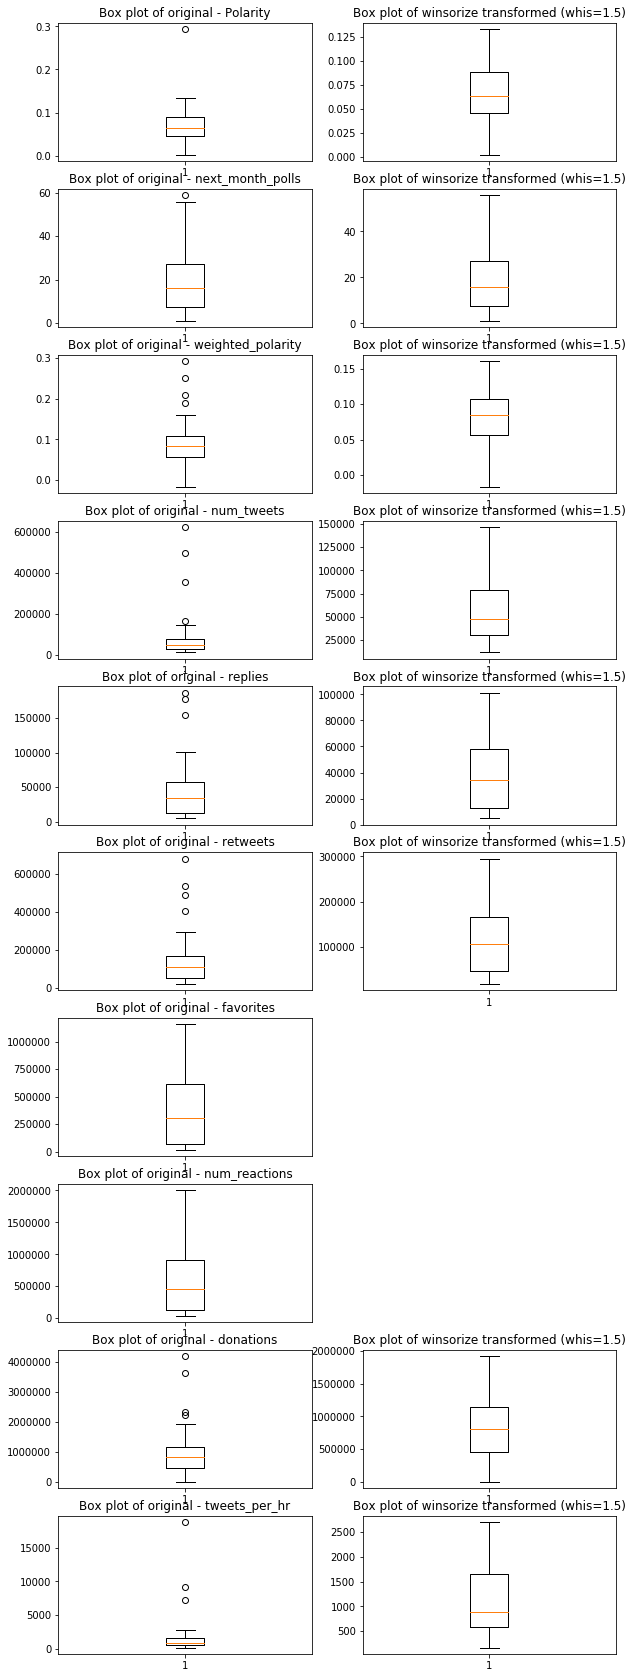

In [173]:
from scipy.stats.mstats import winsorize
plt.figure(figsize = (10,30))

plt.subplot(10,2,1)
plt.boxplot(all_tweets['polarity'])
plt.title("Box plot of original - Polarity")

plt.subplot(10,2,2)
plt.boxplot(winsorize(all_tweets['polarity'], (0, 0.03)))
plt.title("Box plot of winsorize transformed (whis=1.5)")

plt.subplot(10,2,3)
plt.boxplot(all_tweets['next_month_polls'])
plt.title("Box plot of original - next_month_polls")

plt.subplot(10,2,4)
plt.boxplot(winsorize(all_tweets['next_month_polls'], (0, 0.03)))
plt.title("Box plot of winsorize transformed (whis=1.5)")

plt.subplot(10,2,5)
plt.boxplot(all_tweets['weighted_polarity'])
plt.title("Box plot of original - weighted_polarity")

plt.subplot(10,2,6)
plt.boxplot(winsorize(all_tweets['weighted_polarity'], (0, 0.1)))
plt.title("Box plot of winsorize transformed (whis=1.5)")

plt.subplot(10,2,7)
plt.boxplot(all_tweets['num_tweets'])
plt.title("Box plot of original - num_tweets")

plt.subplot(10,2,8)
plt.boxplot(winsorize(all_tweets['num_tweets'], (0, 0.1)))
plt.title("Box plot of winsorize transformed (whis=1.5)")

plt.subplot(10,2,9)
plt.boxplot(all_tweets['replies'])
plt.title("Box plot of original - replies")

plt.subplot(10,2,10)
plt.boxplot(winsorize(all_tweets['replies'], (0, 0.09)))
plt.title("Box plot of winsorize transformed (whis=1.5)")

plt.subplot(10,2,11)
plt.boxplot(all_tweets['retweets'])
plt.title("Box plot of original - retweets")

plt.subplot(10,2,12)
plt.boxplot(winsorize(all_tweets['retweets'], (0, 0.1)))
plt.title("Box plot of winsorize transformed (whis=1.5)")

plt.subplot(10,2,13)
plt.boxplot(all_tweets['favorites'])
plt.title("Box plot of original - favorites")

plt.subplot(10,2,15)
plt.boxplot(all_tweets['num_reactions'])
plt.title("Box plot of original - num_reactions")

plt.subplot(10,2,17)
plt.boxplot(all_tweets['donations'])
plt.title("Box plot of original - donations")

plt.subplot(10,2,18)
plt.boxplot(winsorize(all_tweets['donations'], (0, 0.1)))
plt.title("Box plot of winsorize transformed (whis=1.5)")

plt.subplot(10,2,19)
plt.boxplot(all_tweets['tweets_per_hr'])
plt.title("Box plot of original - tweets_per_hr")

plt.subplot(10,2,20)
plt.boxplot(winsorize(all_tweets['tweets_per_hr'], (0, 0.08)))
plt.title("Box plot of winsorize transformed (whis=1.5)")



plt.show()

In [295]:
all_tweets_wins = pd.DataFrame()

all_tweets_wins['month'] = all_tweets['month']
all_tweets_wins['candidate'] = all_tweets['candidate']
all_tweets_wins['polarity'] = winsorize(all_tweets['polarity'], (0, 0.03))
all_tweets_wins['next_month_polls'] = winsorize(all_tweets['next_month_polls'], (0, 0.03))
all_tweets_wins['weighted_polarity'] = winsorize(all_tweets['weighted_polarity'], (0, 0.1))
all_tweets_wins['num_tweets'] = winsorize(all_tweets['num_tweets'], (0, 0.1))
all_tweets_wins['replies'] = winsorize(all_tweets['replies'], (0, 0.09))
all_tweets_wins['retweets'] = winsorize(all_tweets['retweets'], (0, 0.1))
all_tweets_wins['num_reactions'] = all_tweets['num_reactions']
all_tweets_wins['favorites'] = all_tweets['favorites']
all_tweets_wins['donations'] = winsorize(all_tweets['donations'], (0, 0.1))
all_tweets_wins['tweets_per_hr'] = winsorize(all_tweets['tweets_per_hr'], (0, 0.08))


## Scaling the Data

In [296]:
scaled_data = all_tweets_wins.copy()

scaled_data['next_month_polls'] = (all_tweets_wins.next_month_polls - all_tweets_wins.next_month_polls.mean()) / all_tweets_wins.next_month_polls.std()
scaled_data['polarity'] = (all_tweets_wins.polarity - all_tweets_wins.polarity.mean()) / all_tweets_wins.polarity.std()
scaled_data['weighted_polarity'] = (all_tweets_wins.weighted_polarity - all_tweets_wins.weighted_polarity.mean()) / all_tweets_wins.weighted_polarity.std()
scaled_data['num_tweets'] = (all_tweets_wins.num_tweets - all_tweets_wins.num_tweets.mean()) / all_tweets_wins.num_tweets.std()
scaled_data['replies'] = (all_tweets_wins.replies - all_tweets_wins.replies.mean()) / all_tweets_wins.replies.std()
scaled_data['retweets'] = (all_tweets_wins.retweets - all_tweets_wins.retweets.mean()) / all_tweets_wins.retweets.std()
scaled_data['favorites'] = (all_tweets_wins.favorites - all_tweets_wins.favorites.mean()) / all_tweets_wins.favorites.std()
scaled_data['num_reactions'] = (all_tweets_wins.num_reactions - all_tweets_wins.num_reactions.mean()) / all_tweets_wins.num_reactions.std()
scaled_data['donations'] = (all_tweets_wins.donations - all_tweets_wins.donations.mean()) / all_tweets_wins.donations.std()
scaled_data['tweets_per_hr'] = (all_tweets_wins.tweets_per_hr - all_tweets_wins.tweets_per_hr.mean()) / all_tweets_wins.tweets_per_hr.std()
scaled_data.head(40)


,month,candidate,polarity,next_month_polls,weighted_polarity,num_tweets,replies,retweets,num_reactions,favorites,donations,tweets_per_hr
0,2019-08,Biden,-1.447767,0.522785,-1.441729,0.230432,1.095281,0.767046,0.578710,0.632008,0.377728,-0.057907
1,2019-07,Biden,-0.848014,0.271037,0.272699,0.299240,1.888051,1.949389,1.923955,1.974385,-0.858779,0.449454
2,2019-06,Biden,-0.897078,0.668589,-0.921328,-0.961742,-0.610213,-0.861799,-0.666030,-0.615315,-0.039570,-0.303754
3,2019-05,Biden,-0.782842,1.201193,-0.661313,-0.916734,-0.368361,-0.227223,-0.321173,-0.294466,-0.952207,-0.190471
4,2019-09,Biden,-0.804520,0.686104,-0.341760,0.197393,1.888051,1.360562,1.119635,1.197649,0.099981,0.579609
5,2019-08,Warren,-2.165053,-0.409212,-2.336652,0.298284,1.478258,1.949389,2.096527,2.187508,0.430936,0.751943
6,2019-07,Warren,0.423424,-0.372337,0.485643,0.336056,0.589608,0.134339,0.705062,1.015358,-0.186328,-0.200112
7,2019-06,Warren,1.214201,-0.555290,1.694604,0.400996,1.484157,1.181088,1.583749,1.948672,-0.177388,-0.094061
8,2019-05,Warren,0.587700,-0.890303,0.504471,0.344793,0.346035,0.360858,0.616966,0.853760,-0.480977,-0.571293
9,2019-09,Warren,0.617811,-0.103930,1.503446,0.226996,0.982789,0.800044,1.035032,1.293608,0.004628,-0.291702


# Data Modeling and Analysis

In [299]:
scaled_data[['polarity','weighted_polarity', 'num_tweets', 
             'replies', 'retweets', 'favorites','num_reactions',
             'donations', 'tweets_per_hr','Biden', 'Buttigieg',
             'Clinton','Cruz','Sanders','Sanders2016','Trump',
             'Warren']].corr()['num_tweets'][:].sort_values(ascending=False)

num_tweets           1.000000
tweets_per_hr        0.946972
retweets             0.645495
Clinton              0.643841
replies              0.542860
num_reactions        0.423780
Trump                0.320820
favorites            0.271961
donations            0.200627
Warren               0.123035
Biden               -0.088147
Sanders             -0.153570
Sanders2016         -0.186486
polarity            -0.197642
Cruz                -0.291461
weighted_polarity   -0.300844
Buttigieg           -0.368031
Name: num_tweets, dtype: float64

### Simple Linear Regression

In [298]:
dummmies = pd.DataFrame()
dummies = pd.get_dummies(scaled_data.candidate, drop_first=False)
scaled_data = pd.merge(scaled_data, dummies, left_index=True, right_index=True)

Without dummies

In [300]:
# Y is the target variable
Y = scaled_data['next_month_polls']

X = scaled_data[['polarity','weighted_polarity', 'num_tweets', 
                 'replies', 'retweets', 'favorites','num_reactions',
                 'donations', 'tweets_per_hr']]

# X is the feature set

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)



print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The number of observations in training set is 32
The number of observations in test set is 8
R-squared of the model in the training set is: 0.7262228924948957
-----Test set statistics-----
R-squared of the model in the test set is: 0.30797980708781814
Mean absolute error of the prediction is: 0.6196307058104701
Mean squared error of the prediction is: 0.8512230084805525
Root mean squared error of the prediction is: 0.9226174767911957
Mean absolute percentage error of the prediction is: 81.55921923004298


With dummies

In [289]:
# Y is the target variable
Y = scaled_data['next_month_polls']

X = scaled_data[['polarity','weighted_polarity', 'num_tweets', 
                 'replies', 'retweets', 'favorites','num_reactions',
                 'donations', 'tweets_per_hr','Biden', 'Buttigieg',
                 'Clinton','Cruz','Sanders','Sanders2016','Trump','Warren']]

# X is the feature set

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)



print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The number of observations in training set is 32
The number of observations in test set is 8
R-squared of the model in the training set is: 0.962629333621429
-----Test set statistics-----
R-squared of the model in the test set is: 0.6999195681354926
Mean absolute error of the prediction is: 0.4908165218976471
Mean squared error of the prediction is: 0.36911548335449296
Root mean squared error of the prediction is: 0.6075487497760924
Mean absolute percentage error of the prediction is: 123.695283644141



Coefficients: 
 [ 0.16662078 -0.16362077 -0.15320978  0.90913298 -0.77603143  1.78451634
 -2.32200718  0.18361678  1.2550612 ]

Intercept: 
 -2.799128817907828e-16


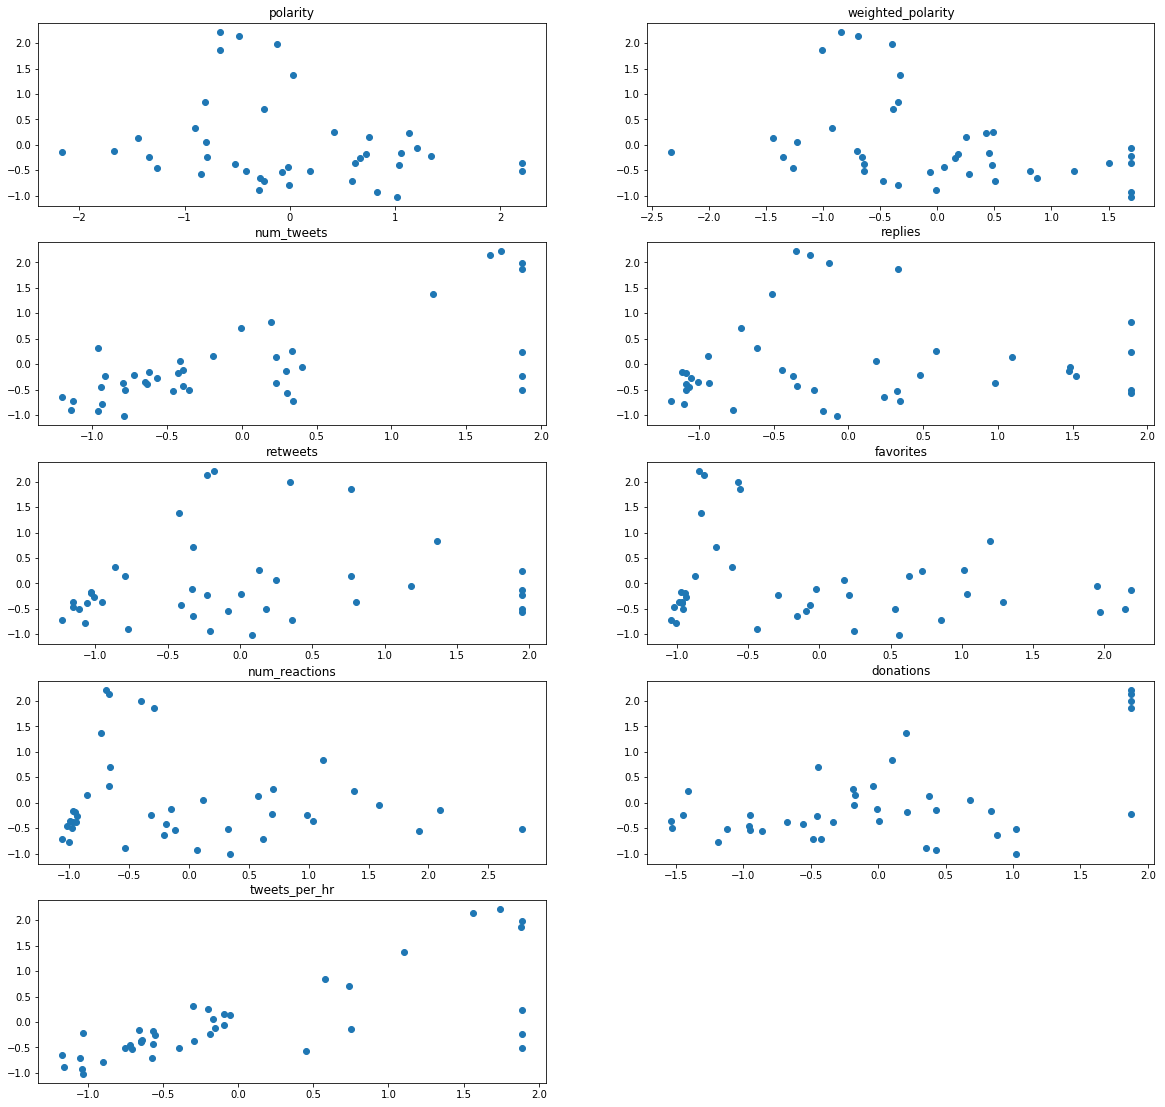

In [301]:
from sklearn import linear_model

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(scaled_data[['polarity','weighted_polarity','num_tweets','replies',
                             'retweets','favorites','num_reactions','donations', 'tweets_per_hr']], 
                scaled_data['next_month_polls'])


# predictions of the linear regression
predictions = lrm_example.predict(scaled_data[['polarity','weighted_polarity','num_tweets','replies',
                                               'retweets','favorites','num_reactions','donations',
                                               'tweets_per_hr']])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

features = ['polarity','weighted_polarity','num_tweets','replies',
            'retweets','favorites','num_reactions','donations', 'tweets_per_hr']
titles = ['polarity','weighted_polarity','num_tweets','replies',
            'retweets','favorites','num_reactions','donations', 'tweets_per_hr']

plt.figure(figsize=(20,80))

for i in range(len(features)):
    plt.subplot(20,2,i+1)
    plt.scatter(scaled_data[features[i]], predictions)
    plt.title(features[i])
    
plt.show()

In [302]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the tweets to polls prediction model is: {}".format(np.mean(errors)))

Mean of the errors in the tweets to polls prediction model is: -0.03445449051019649


Hmmm...not terrible, but still not very good. Should be as close to 0 as possible.

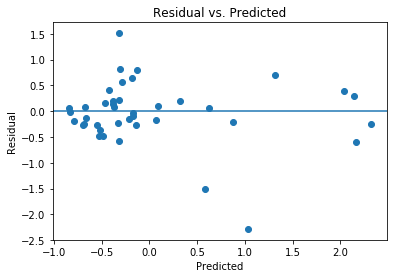

In [303]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

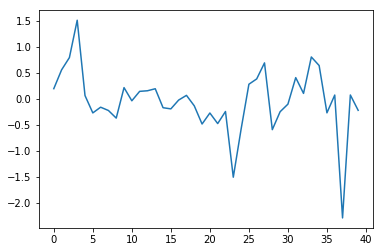

In [304]:
plt.plot(errors)
plt.show()

It seems that the error terms of our model are mostly uncorrelated with each other.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


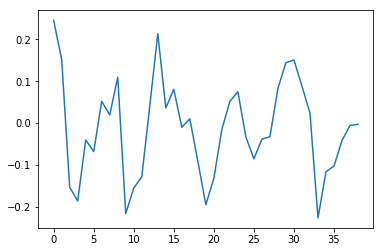

In [305]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

So, the autocorrelation between the errors of tweets to polls prediction model is low, but could be better (ranging between -0.2 and 0.2).

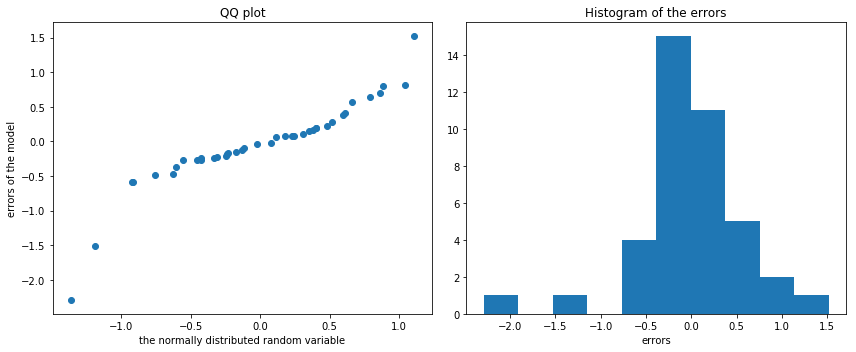

In [306]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [307]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 35.05499010176763 and p value is 2.4428995937242348e-08
Normality test statistics is 17.562588452065718 and p value is 0.0001535791903328309


The p-values of both tests indicate that our errors are not normally distributed, and in order to measure the statistical significance of our estimated coefficients, error terms must be normally distributed.

### OLS Regression

Without dummies

In [308]:
# Y is the target variable
Y = scaled_data['next_month_polls']
# X is the feature set which includes
X = scaled_data[['polarity','weighted_polarity', 'num_tweets', 
                'replies', 'retweets', 'favorites','num_reactions',
                'donations', 'tweets_per_hr']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)
print('\nR squared: \n', lrm.score(X,Y))


Coefficients: 
 [ 0.16662078 -0.16362077 -0.15320978  0.90913298 -0.77603143  1.78451634
 -2.32200718  0.18361678  1.2550612 ]

Intercept: 
 -2.799128817907828e-16

R squared: 
 0.7097979050073477


With dummies

In [309]:
# Y is the target variable
Y = scaled_data['next_month_polls']
# X is the feature set which includes
X = scaled_data[['polarity','weighted_polarity', 'num_tweets', 
                'replies', 'retweets', 'favorites','num_reactions',
                'donations', 'tweets_per_hr', 'Biden', 'Buttigieg',
                 'Clinton','Cruz','Sanders','Sanders2016','Trump','Warren']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)
print('\nR squared: \n', lrm.score(X,Y))


Coefficients: 
 [ 0.34013819 -0.12131188 -0.45954746  0.3533113  -0.62639038 -1.15150302
  1.39301775  0.01462578  0.59867255  0.79281558 -0.66685044  1.96870542
 -0.91458246  0.09065659 -0.0155209  -1.19370192 -0.06152188]

Intercept: 
 3.623316924272757e-15

R squared: 
 0.9296312951769219


Without dummies

In [310]:
# Y is the target variable
Y = scaled_data['next_month_polls']
# X is the feature set which includes
X = scaled_data[['polarity','weighted_polarity', 'num_tweets', 
                'replies', 'retweets', 'favorites','num_reactions',
                'donations', 'tweets_per_hr']]

# We add constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# We print the summary results.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       next_month_polls   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     8.153
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           5.24e-06
Time:                        20:21:45   Log-Likelihood:                -31.508
No. Observations:                  40   AIC:                             83.02
Df Residuals:                      30   BIC:                             99.90
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              9.021e-17      0.09

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


With dummies

In [311]:
# Y is the target variable
Y = scaled_data['next_month_polls']
# X is the feature set which includes
X = scaled_data[['polarity','weighted_polarity', 'num_tweets', 
                'replies', 'retweets', 'favorites','num_reactions',
                'donations', 'tweets_per_hr','Biden', 'Buttigieg',
                 'Clinton','Cruz','Sanders','Sanders2016','Trump','Warren']]

# We add constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# We print the summary results.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       next_month_polls   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     18.99
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           1.40e-09
Time:                        20:22:02   Log-Likelihood:                -3.1711
No. Observations:                  40   AIC:                             40.34
Df Residuals:                      23   BIC:                             69.05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.596e-16      0.04

Without Dummies

In [237]:
# This is the interaction between the number of tweets and the average polarity
scaled_data["num_tweets_polarity"] = scaled_data.num_tweets * scaled_data.polarity
scaled_data["num_tweets_donations"] = scaled_data.num_tweets * scaled_data.donations
scaled_data["tweets_per_hr_donations"] = scaled_data.tweets_per_hr * scaled_data.donations
scaled_data['polarity_donations'] = scaled_data.polarity * scaled_data.donations
scaled_data['num_reactions_polarity'] = scaled_data.polarity * scaled_data.num_reactions

# X is the feature set which includes
X = scaled_data[['polarity','weighted_polarity','num_tweets','replies','retweets','favorites',
                 'num_reactions','donations','tweets_per_hr','num_tweets_polarity','num_tweets_donations',
                 'tweets_per_hr_donations','polarity_donations', 'num_reactions_polarity']]

# We add a constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       next_month_polls   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     6.262
Date:                Mon, 16 Dec 2019   Prob (F-statistic):           3.83e-05
Time:                        19:11:09   Log-Likelihood:                -26.141
No. Observations:                  40   AIC:                             82.28
Df Residuals:                      25   BIC:                             107.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

With dummies

In [312]:
# This is the interaction between the number of tweets and the average polarity
scaled_data["num_tweets_polarity"] = scaled_data.num_tweets * scaled_data.polarity
scaled_data["num_tweets_donations"] = scaled_data.num_tweets * scaled_data.donations
scaled_data["tweets_per_hr_donations"] = scaled_data.tweets_per_hr * scaled_data.donations
scaled_data['polarity_donations'] = scaled_data.polarity * scaled_data.donations
scaled_data['num_reactions_polarity'] = scaled_data.polarity * scaled_data.num_reactions

# X is the feature set which includes
X = scaled_data[['polarity','weighted_polarity','num_tweets','replies','retweets','favorites',
                 'num_reactions','donations','tweets_per_hr','num_tweets_polarity','num_tweets_donations',
                 'tweets_per_hr_donations','polarity_donations', 'num_reactions_polarity', 
                'Biden', 'Buttigieg','Clinton','Cruz','Sanders','Sanders2016','Trump','Warren']]

# We add a constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       next_month_polls   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     29.15
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           6.66e-10
Time:                        20:23:23   Log-Likelihood:                 14.862
No. Observations:                  40   AIC:                             14.28
Df Residuals:                      18   BIC:                             51.43
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [284]:
 # This is the interaction between the number of tweets and the average polarity
scaled_data["num_tweets_polarity"] = scaled_data.num_tweets * scaled_data.polarity
scaled_data["num_tweets_donations"] = scaled_data.num_tweets * scaled_data.donations
scaled_data["tweets_per_hr_donations"] = scaled_data.tweets_per_hr * scaled_data.donations
scaled_data['polarity_donations'] = scaled_data.polarity * scaled_data.donations
scaled_data['num_reactions_polarity'] = scaled_data.polarity * scaled_data.num_reactions

# X is the feature set which includes
X = scaled_data[['polarity','weighted_polarity','num_tweets','replies','retweets','favorites',
                 'num_reactions','donations','tweets_per_hr','num_tweets_polarity','num_tweets_donations',
                 'tweets_per_hr_donations','polarity_donations', 'num_reactions_polarity',
                'Biden', 'Buttigieg','Clinton','Cruz','Sanders','Sanders2016','Trump','Warren']]

# We add a constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       next_month_polls   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     29.15
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           6.66e-10
Time:                        19:56:19   Log-Likelihood:                 14.862
No. Observations:                  40   AIC:                             14.28
Df Residuals:                      18   BIC:                             51.43
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

### Evaluating the Model

Adding more variables seems to make everything less statistically significant. Tweets per hr is the most significant variable, followed closely by number of reactions, favorites, and replies, which are all more or less the same measurement. The relationship between number of tweets and donations is interesting. The coefficient is 0.98 which I would take to mean the relationship is 1 to 1--for every tweet, there is a correlating $1 donation on average each month.

In both versions of the OLS model (the one without added variable interactions and the one with the added variable interactions), the P-value for the F-statistic is very close to 0, meaning that our features add some information to the reduced model and our model is useful in explaining polling data. However, F-tests don't quantify how much information our model contributes--this requires R-squared. 

The R-squared of our polling predictions model is 0.778, which means it explains about 78\% of the variance in the model. After adding the 4 extra interactive features, the R-squared went up 0.06 which indicates that the interaction of the variables explains some previously unexplained variance in the charges. There is room for improvement here, but with an R-squared value of 0.78 we probably don't need to worry about over-fitting at least. Adjusted R-squared does the same job as R-squared, but it is adjusted according to the number of features included in the model. Our adjusted R-squared isn't too much lower than our R-squared (0.654), which is a good sign.

The two models above are relatively equal in terms of which one is better than the other when considering R-squared, F-stat, AIC, and BIC, but the model with the additional features is slightly better.

At first look, when we add the candidates as dummy variables, the R-squared is really high, wow, that's great! But...I think there is some over-fitting going on here because of the amount of variables this adds, since there are 8 new columns now. Then again, the R-squared of the training set is 0.9626 and the R-squared of the test set is 0.6999. These numbers are actually pretty close together, which indicates that overfitting might actually not be a factor. Regardless, tt might show some interesting results, so we'll keep both models with the dummy variables and without.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


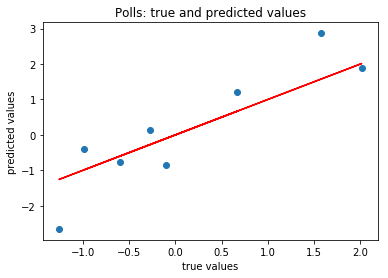

Mean absolute error of the prediction is: 0.6646393130187522
Mean squared error of the prediction is: 0.8773211841321515
Root mean squared error of the prediction is: 0.9366542500475571
Mean absolute percentage error of the prediction is: 99.51432284170663


In [336]:
# Y is the target variable
Y = scaled_data['next_month_polls']

# X is the feature set which includes
X = scaled_data[['polarity','weighted_polarity','num_tweets','replies','retweets','favorites',
                 'num_reactions','donations','tweets_per_hr','num_tweets_polarity','num_tweets_donations',
                 'tweets_per_hr_donations','polarity_donations', 'num_reactions_polarity',
                'Biden', 'Buttigieg','Clinton','Cruz','Sanders','Sanders2016','Trump','Warren']]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Polls: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


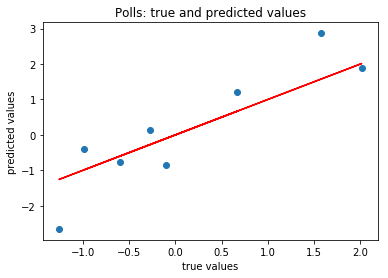

Mean absolute error of the prediction is: 0.4908165218976471
Mean squared error of the prediction is: 0.36911548335449296
Root mean squared error of the prediction is: 0.6075487497760924
Mean absolute percentage error of the prediction is: 123.695283644141


In [285]:
# Y is the target variable
Y = scaled_data['next_month_polls']

# X is the feature set which includes
X = scaled_data[['polarity','weighted_polarity','num_tweets','replies','retweets','favorites',
                 'num_reactions','donations','tweets_per_hr','num_tweets_polarity','num_tweets_donations',
                 'tweets_per_hr_donations','polarity_donations', 'num_reactions_polarity',
                'Biden', 'Buttigieg','Clinton','Cruz','Sanders','Sanders2016','Trump','Warren']]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Polls: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


All of these stats are better than the first linear regression model we ran! It looks like the model has an error of 67%...which is not very good, but probably has to do with the small amount of data we are working with. Let's look at some other linear regression models and compare them to our OLS model to see which is the best.

When we add the dummy variables, the error values go down pretty significantly, but the absolute percentage error goes up by a factor of 2...will have to investigate what this means.


## Ridge Regression

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


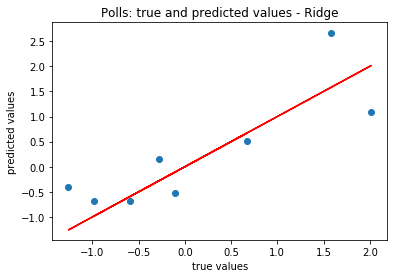

Best alpha value is: 1.0
R-squared of the model in training set is: 0.9557024818341495
-----Test set statistics-----
R-squared of the model in test set is: 0.6716945241923535
Mean absolute error of the prediction is: 0.5297341004863062
Mean squared error of the prediction is: 0.40383384427206737
Root mean squared error of the prediction is: 0.6354792241073404
Mean absolute percentage error of the prediction is: 100.66046950353768


In [337]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
from sklearn.linear_model import Ridge

# Y is the target variable
Y = scaled_data['next_month_polls']

# X is the feature set which includes
X = scaled_data[['polarity','weighted_polarity','num_tweets','replies','retweets','favorites',
                 'num_reactions','donations','tweets_per_hr','num_tweets_polarity','num_tweets_donations',
                 'tweets_per_hr_donations','polarity_donations', 'num_reactions_polarity',
                'Biden', 'Buttigieg','Clinton','Cruz','Sanders','Sanders2016','Trump','Warren']]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)


# results = sm.OLS(y_train, X_train).fit()

# We are making predictions here
# y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Polls: true and predicted values - Ridge")
plt.show()

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

## Lasso Regression

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0724699895728044, tolerance: 0.0020856743268347867
  tol, rng, random, positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10073464350507885, tolerance: 0.0020856743268347867
  tol, rng, random, positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_mo

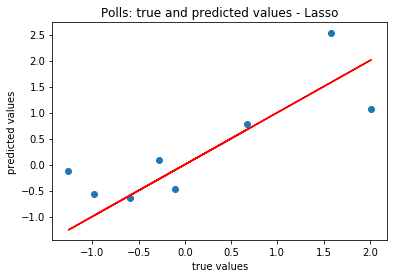

Best alpha value is: 0.01
R-squared of the model in training set is: 0.95684973684104
-----Test set statistics-----
R-squared of the model in test set is: 0.6360186810381555
Mean absolute error of the prediction is: 0.5444770539218882
Mean squared error of the prediction is: 0.44771709919848907
Root mean squared error of the prediction is: 0.6691166558967794
Mean absolute percentage error of the prediction is: 94.69068440196304


In [338]:
from sklearn.linear_model import Lasso
# Y is the target variable
Y = scaled_data['next_month_polls']

# X is the feature set which includes
X = scaled_data[['polarity','weighted_polarity','num_tweets','replies','retweets','favorites',
                 'num_reactions','donations','tweets_per_hr','num_tweets_polarity','num_tweets_donations',
                 'tweets_per_hr_donations','polarity_donations', 'num_reactions_polarity',
                'Biden', 'Buttigieg','Clinton','Cruz','Sanders','Sanders2016','Trump','Warren']]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Polls: true and predicted values - Lasso")
plt.show()

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

## ElasticNet Regression

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005533746635232095, tolerance: 0.0020856743268347867
  tol, rng, random, positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09988032276652907, tolerance: 0.0020856743268347867
  tol, rng, random, positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_

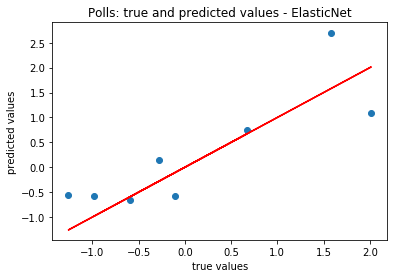

Best alpha value is: 0.01
R-squared of the model in training set is: 0.9650656595462581
-----Test set statistics-----
R-squared of the model in test set is: 0.679484042098564
Mean absolute error of the prediction is: 0.5215329746553772
Mean squared error of the prediction is: 0.39425230758477176
Root mean squared error of the prediction is: 0.6278951405965584
Mean absolute percentage error of the prediction is: 104.52340490098415


In [339]:
from sklearn.linear_model import ElasticNet

# Y is the target variable
Y = scaled_data['next_month_polls']

# X is the feature set which includes
X = scaled_data[['polarity','weighted_polarity','num_tweets','replies','retweets','favorites',
                 'num_reactions','donations','tweets_per_hr','num_tweets_polarity','num_tweets_donations',
                 'tweets_per_hr_donations','polarity_donations', 'num_reactions_polarity',
                'Biden', 'Buttigieg','Clinton','Cruz','Sanders','Sanders2016','Trump','Warren']]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

plt.scatter(y_test, y_preds_test)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Polls: true and predicted values - ElasticNet")
plt.show()

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

These 4 models produce relatively similar results, but I think OLS is still the best, although the others follow very closely behind.

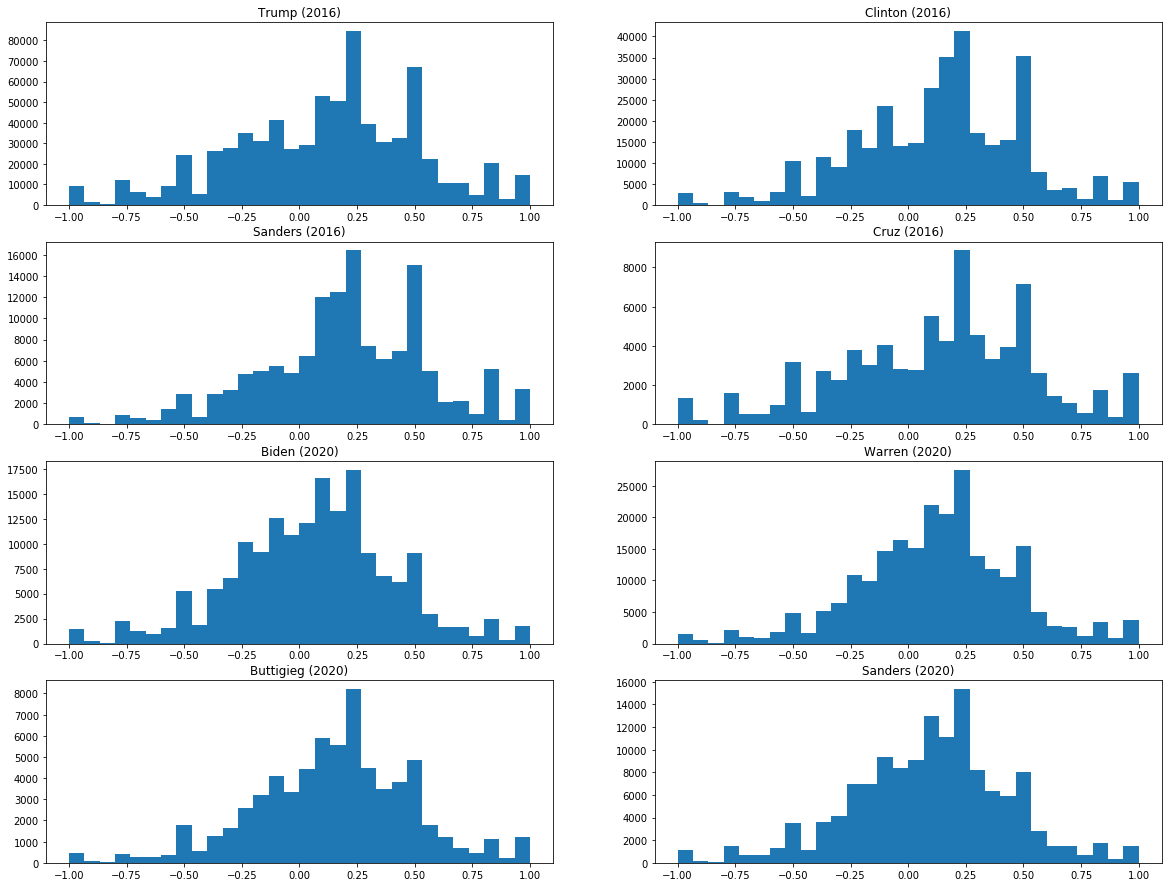

In [110]:
## Plotting the distribution of polarity for each candidate

tweets1 = tweets[tweets.polarity != 0]
trumpdf = trump_tweets2016[trump_tweets2016.polarity != 0]
clintondf = clinton_tweets2016[clinton_tweets2016.polarity != 0]
sandersdf2 = sanders_tweets2016[sanders_tweets2016.polarity != 0]
cruzdf = cruz_tweets2016[cruz_tweets2016.polarity != 0]
bidendf = tweets1[tweets1.biden_only != 0]
warrendf = tweets1[tweets1.warren_only != 0]
buttigiegdf = tweets1[tweets1.buttigieg_only != 0]
sandersdf = tweets1[tweets1.sanders_only != 0]

candidates = [trumpdf, clintondf, sandersdf2, cruzdf, bidendf, warrendf, buttigiegdf, sandersdf]
titles = ['Trump (2016)', 'Clinton (2016)', 'Sanders (2016)', 'Cruz (2016)', 
          'Biden (2020)', 'Warren (2020)', 'Buttigieg (2020)', 'Sanders (2020)']

plt.figure(figsize=(20,80))

for i in range(len(candidates)):
    plt.subplot(20,2,i+1)
    plt.hist(candidates[i].polarity, bins=30)
    plt.title(titles[i])
    
plt.show()